In [1]:
import h5py
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
from pathlib import Path
import pyfftw

import bacco

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import plotter
import plot_utils
import utils
import compute_statistics as cs
import data_loader
import generate_params as genp

%load_ext autoreload
%autoreload 2

2025-12-09 19:23:59.442503: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-09 19:23:59.544594: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-09 19:23:59.544635: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-09 19:23:59.557422: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-09 19:23:59.587202: I tensorflow/core/platform/cpu_feature_guar

In [2]:
%matplotlib inline
mpl.pyplot.style.use('default')
mpl.pyplot.close('all')

font, rcnew = plot_utils.matplotlib_default_config()
mpl.rc('font', **font)
mpl.pyplot.rcParams.update(rcnew)
mpl.pyplot.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'

mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

### fixed cosmo - for error bars 

In [3]:
data_mode = 'muchisimocks'
statistics = ['pk']

### train
# tag_params = '_p5_n10000'
# tag_biasparams = '_biaszen_p4_n10000'
# tag_noise = '_noise_p5_n10000'
# tag_Anoise = '_An_p1_n10000'
### test
# tag_params = '_test_p5_n1000'
# tag_biasparams = '_biaszen_p4_n1000'
# tag_noise = '_noise_test_p5_n1000'
# tag_Anoise = '_An_p1_n1000'
# tag_datagen = ''
## cosmic variance (quijote)
tag_params="_quijote_p0_n1000"
tag_biasparams="_b1000_p0_n1"
tag_noise="_noise_quijote_p0_n1000"
tag_Anoise="_An1_p0_n1"
tag_datagen = ''
kwargs_data = {
    'tag_datagen': tag_datagen
}

tag_stats = f'_{"_".join(statistics)}'    
tag_data = '_'+data_mode + tag_stats + tag_params + tag_biasparams + tag_datagen
k, y, y_err, idxs_params, params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = \
            data_loader.load_data(data_mode, statistics, 
                                    tag_params, tag_biasparams,
                                    tag_noise=tag_noise, tag_Anoise=tag_Anoise,
                                    tag_data=tag_data,
                                    kwargs=kwargs_data)
            
# unpack the power spectrum
k, y, y_err = k[0], y[0], y_err[0]
print(y.shape)
print(k.shape)

dir_statistics: /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_quijote_p0_n1000_b1000_p0_n1_noise_quijote_p0_n1000_An1_p0_n1
Loading muchisimocks data from /scratch/kstoreyf/muchisimocks/data/pnns_mlib/pnns_quijote_p0_n1000
Found 1000 diff cosmo pnns in /scratch/kstoreyf/muchisimocks/data/pnns_mlib/pnns_quijote_p0_n1000


Loaded pk data with shape (1000, 30)
fn_mask: ../data/masks/mask_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1.txt
Loading from ../data/masks/mask_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1.txt (already exists)
Masked 1 out of 30 bins
(29,) (1000, 30) (1000, 30) (30,)
(1000, 29)
(29,)


In [4]:
mask = data_loader.get_Pk_mask(tag_data)

fn_mask: ../data/masks/mask_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1.txt
Loading from ../data/masks/mask_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1.txt (already exists)


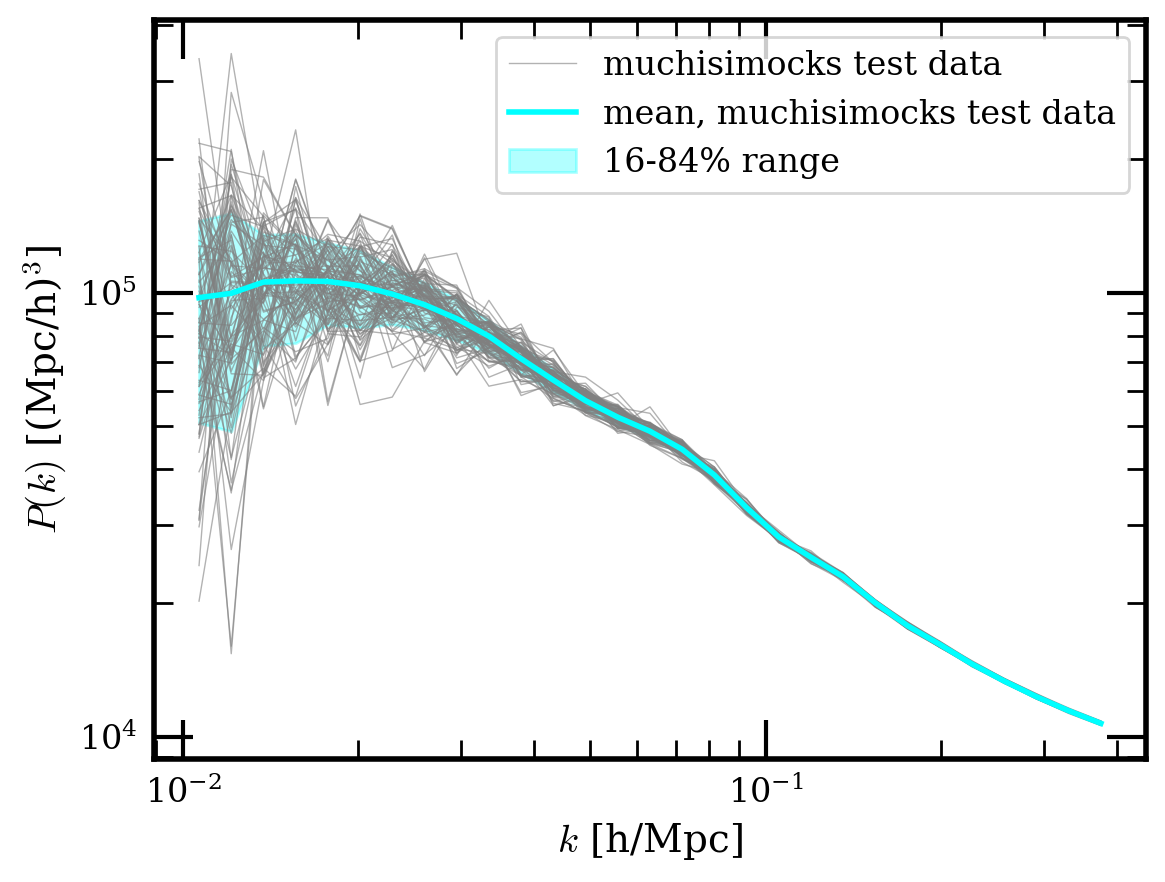

In [5]:
n_plot = 100
first = True
for i in range(n_plot):
    if first:
        label = 'muchisimocks test data'
        first = False
    else:
        label = None
    plt.plot(k, y[i], color='grey', alpha=0.6, lw=0.5, label=label)

mean = np.mean(y, axis=0)
p16 = np.percentile(y, 16, axis=0)
p84 = np.percentile(y, 84, axis=0)
plt.plot(k, mean, color='cyan', lw=2, label='mean, muchisimocks test data')
plt.fill_between(k, p16, p84, color='cyan', alpha=0.3, label=r'16-84% range')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [h/Mpc]', fontsize=14)
plt.ylabel(r'$P(k)$ [(Mpc/h)$^3$]', fontsize=14)
plt.legend(fontsize=12)

In [6]:
err_hi = p84 - mean
err_lo = mean - p16

### loop over number densities

In [7]:
box_size = 1000.0


Load SHAMe data

In [8]:
tags_mock = ['_nbar0.00011', '_nbar0.00022', '_nbar0.00054']

k_mock_arr, y_mock_arr, y_err_mock_arr = [], [], []
for tag_mock in tags_mock:
    data_mode_test = 'shame'
    tag_data_train = None # this is used for mask; we get it below 
    statistics = ['pk', 'bispec']
    k_mock, y_mock, y_err_mock = data_loader.load_data_ood(data_mode_test, statistics, tag_mock, tag_data=tag_data_train)
    k_mock_arr.append(k_mock)
    y_mock_arr.append(y_mock)
    y_err_mock_arr.append(y_err_mock)

Loaded pk with shape (30,)
Loaded pk data with shape (30,)
No tag_data provided, so not masking data
Loaded bispec with shape (50,)
Loaded bispec data with shape (50,)
No tag_data provided, so not masking data
Loaded pk with shape (30,)
Loaded pk data with shape (30,)
No tag_data provided, so not masking data
Loaded bispec with shape (50,)
Loaded bispec data with shape (50,)
No tag_data provided, so not masking data
Loaded pk with shape (30,)
Loaded pk data with shape (30,)
No tag_data provided, so not masking data
Loaded bispec with shape (50,)
Loaded bispec data with shape (50,)
No tag_data provided, so not masking data


Load bias fields, make noiseless field 

In [9]:
dir_mocks = f'/scratch/kstoreyf/muchisimocks/muchisimocks_lib_ood/shame'
subdir_prefix = 'mock'
idx_mock = 0
fn_fields = f'{dir_mocks}/{subdir_prefix}{idx_mock}/bias_fields_eul_deconvolved_{idx_mock}.npy'
bias_terms_eul = np.load(fn_fields)

Add noise

In [10]:
noise_field_arr = []
for i, tag_mock in enumerate(tags_mock):
    
    nbar = float(tag_mock.split('nbar')[-1])

    n_grid = 128
    box_size = 1000.0  # Mpc/h
    cell_size = box_size / n_grid  # Mpc/h per cell
    cell_volume = cell_size**3
    rms_cell = 1 / np.sqrt(nbar * cell_volume)

    rng = np.random.default_rng(seed=42)

    noise_field = rms_cell * rng.standard_normal((n_grid, n_grid, n_grid))
    noise_field /= n_grid**3
    noise_field_arr.append(noise_field)

In [11]:
for i, tag_mock in enumerate(tags_mock):
    nbar = float(tag_mock.split('nbar')[-1])
    print(nbar)

0.00011
0.00022
0.00054


In [12]:
n_grid_orig = 512 # this is for the muchisimocks pipeline which is 512, even tho the shame tracer field was diff (n_grid_orig_mock)

tracer_field_arr = []
tracer_field_noiseless_arr = []
for i, tag_mock in enumerate(tags_mock):
    
    param_dict = data_loader.load_params_ood('shame', tag_mock)
    cosmo = utils.get_cosmo(param_dict)
    bias_vector = [param_dict[name] for name in utils.biasparam_names_ordered]
    
    tracer_field_noiseless = utils.get_tracer_field(bias_terms_eul, bias_vector,
                                                    n_grid_norm=n_grid_orig)
    tracer_field_noiseless_arr.append(tracer_field_noiseless)
    
    A_noise = 1
    tracer_field = utils.get_tracer_field(bias_terms_eul, bias_vector,
                                          noise_field=noise_field_arr[i], A_noise=A_noise, n_grid_norm=n_grid_orig)
    tracer_field_arr.append(tracer_field)

Compute statistics

In [13]:
pk_obj_arr = []
pk_obj_noiseless_arr = []
for i, tag_mock in enumerate(tags_mock):
    
    # cosmos are all the same, just grab one
    pk_obj_noiseless = cs.compute_pk(tracer_field_noiseless_arr[i], cosmo, box_size,
                        n_threads=1, fn_stat=None)
    pk_obj_noiseless_arr.append(pk_obj_noiseless)
    
    pk_obj = cs.compute_pk(tracer_field_arr[i], cosmo, box_size,
                            n_threads=1, fn_stat=None)
    pk_obj_arr.append(pk_obj)

Computing pk, using n_grid =  128


2025-11-27 10:33:07,026 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


2025-11-27 10:33:08,606 bacco.statistics :  ...done in 1.58 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.014938 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.043198 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000123 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2025-11-27 10:33:08,607 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-11-27 10:33:08,685 bacco.statistics :  ...done in 0.0784 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00241 (grid1) 1.00241 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013544 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.043240 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000134 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2025-11-27 10:33:08,687 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.014413 sec
bacco.power : Counting modes


2025-11-27 10:33:08,779 bacco.statistics :  ...done in 0.092 s


bacco.power : done counting modes in 0.043037 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000138 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2025-11-27 10:33:08,780 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00171 (grid1) 1.00171 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.014277 sec
bacco.power : Counting modes


2025-11-27 10:33:08,873 bacco.statistics :  ...done in 0.0925 s


bacco.power : done counting modes in 0.043048 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000134 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2025-11-27 10:33:08,873 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.014083 sec
bacco.power : Counting modes


2025-11-27 10:33:08,965 bacco.statistics :  ...done in 0.0915 s


bacco.power : done counting modes in 0.043155 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000133 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2025-11-27 10:33:08,966 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00109 (grid1) 1.00109 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.014107 sec
bacco.power : Counting modes


2025-11-27 10:33:09,057 bacco.statistics :  ...done in 0.0906 s


bacco.power : done counting modes in 0.042745 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000133 secs
bacco.power : Deallocating arrays


In [14]:
pk_obj_noise_arr = []
for i, tag_mock in enumerate(tags_mock):
    pk_obj_noise = cs.compute_pk(noise_field_arr[i], cosmo, box_size,
                        n_threads=1, fn_stat=None)
    pk_obj_noise_arr.append(pk_obj_noise)

Computing pk, using n_grid =  128


2025-11-27 10:33:09,498 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-11-27 10:33:09,587 bacco.statistics :  ...done in 0.0894 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.00241481 (grid1) 0.00241481 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.014104 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.043237 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000129 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2025-11-27 10:33:09,589 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-11-27 10:33:09,680 bacco.statistics :  ...done in 0.0912 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.00170753 (grid1) 0.00170753 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013711 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.043344 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000129 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2025-11-27 10:33:09,681 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.00108989 (grid1) 0.00108989 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013860 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.042457 sec
bacco.power : Starting Fourier loop 


2025-11-27 10:33:09,772 bacco.statistics :  ...done in 0.0907 s


bacco.power : done Fourier loop in 0.000128 secs
bacco.power : Deallocating arrays


In [15]:
base = cs.setup_bispsec(box_size, n_grid, n_threads=1)


# Dimensions: [1.00e+03, 1.00e+03, 1.00e+03] Mpc/h
# Center: [0.00e+00, 0.00e+00, 0.00e+00] Mpc/h
# Line-of-sight: global
# Fourier-space grid: [128, 128, 128]
# Fundamental frequency: [0.006, 0.006, 0.006] h/Mpc
# Nyquist frequency: [0.402, 0.402, 0.402] h/Mpc
# Pixel window: none
# Using fftw backend
PolyBin3D setup time: 0.24 s


In [16]:
bspec_arr, bk_corr_arr = [], []
bspec_noiseless_arr, bk_corr_noiseless_arr = [], []
for i, tag_mock in enumerate(tags_mock):
    bspec, bk_corr = cs.compute_bispectrum(base, tracer_field_arr[i])
    bspec_arr.append(bspec)
    bk_corr_arr.append(bk_corr)
    
    bspec_noiseless, bk_corr_noiseless = cs.compute_bispectrum(base, tracer_field_noiseless_arr[i])
    bspec_noiseless_arr.append(bspec_noiseless)
    bk_corr_noiseless_arr.append(bk_corr_noiseless)


Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix



Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix


In [17]:
box_size_mock = 1024.0
import process_catalogs as pc
n_grid_mock = pc.round_to_nearest_even(box_size_mock / (box_size/n_grid))
print("n_grid_mock: ", n_grid_mock)

n_grid_mock:  132


In [18]:
err_lo.shape, mask.shape, pk_obj_noiseless['pk'].shape

((29,), (30,), (30,))

In [19]:
noise_amp_arr = []
for i, tag_mock in enumerate(tags_mock):
    
    nbar = float(tag_mock.split('nbar')[-1])

    n_grid = 128
    box_size = 1000.0  # Mpc/h
    cell_size = box_size / n_grid  # Mpc/h per cell
    cell_volume = cell_size**3
    rms_cell = 1 / np.sqrt(nbar * cell_volume)
    
    noise_amp = rms_cell**2 * box_size**3 / n_grid**3
    noise_amp_arr.append(noise_amp)
    print(f"nbar: {nbar}, noise_amp: {noise_amp}")

nbar: 0.00011, noise_amp: 9090.909090909092
nbar: 0.00022, noise_amp: 4545.454545454545
nbar: 0.00054, noise_amp: 1851.8518518518517


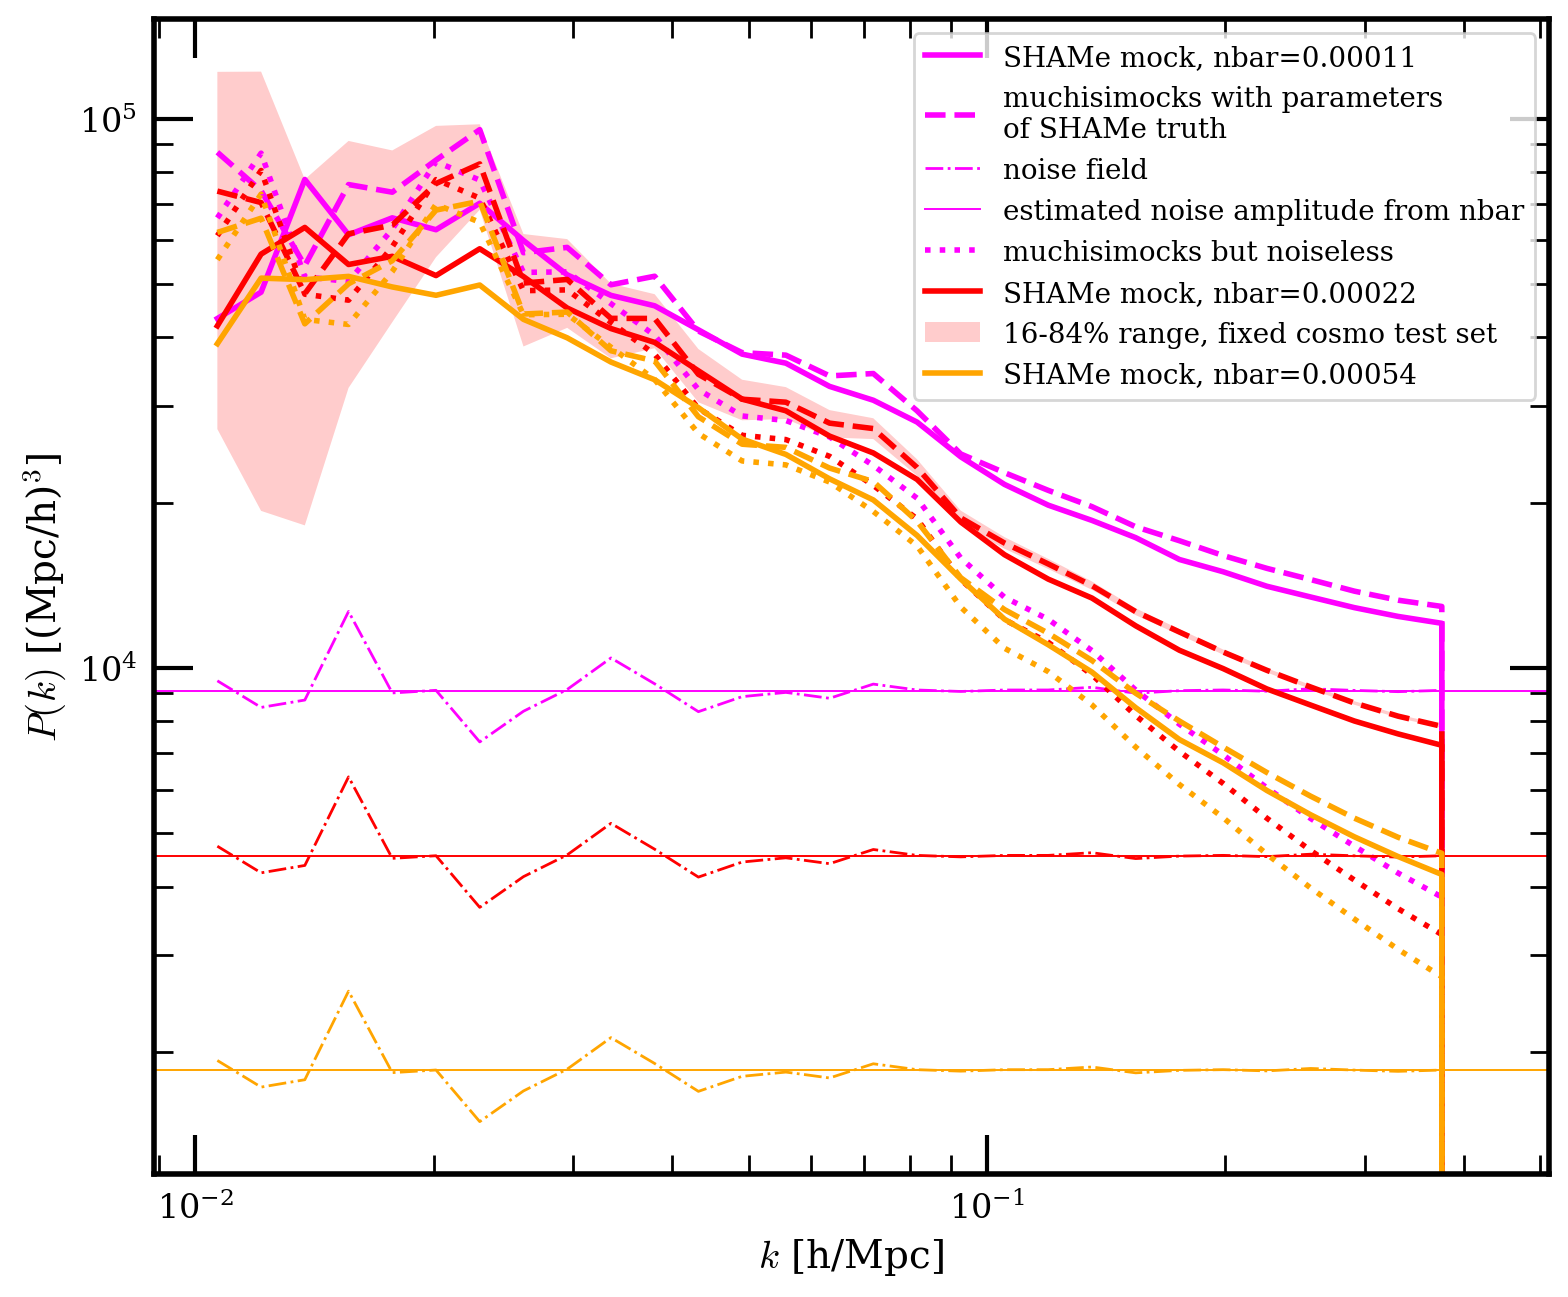

In [20]:
plt.figure(figsize=(9,7.5))
colors = ['magenta', 'red', 'orange']
for i, tag_mock in enumerate(tags_mock):
    k_mock = k_mock_arr[i]
    y_mock = y_mock_arr[i]
    pk_obj = pk_obj_arr[i]

    label = f'SHAMe mock, nbar={tag_mock.split("nbar")[-1]}'
    plt.plot(k_mock[0], y_mock[0], color=colors[i], label=label, lw=2)
    if i==0:
        label_muchisimocks = 'muchisimocks with parameters\nof SHAMe truth'
        label_noise = 'noise field'
        label_noiseamp = 'estimated noise amplitude from nbar'
        label_muchisimocks_noiseless = 'muchisimocks but noiseless'
    else:
        label_muchisimocks = None
        label_noise = None
        label_noiseamp = None
        label_muchisimocks_noiseless = None
    plt.plot(pk_obj['k'], pk_obj['pk'], color=colors[i], ls='--', label=label_muchisimocks, lw=2)
    plt.plot(pk_obj_noise_arr[i]['k'], pk_obj_noise_arr[i]['pk'], color=colors[i], ls='-.', label=label_noise, lw=1)
    
    plt.axhline(noise_amp_arr[i], color=colors[i], ls='-', lw=0.7, label=label_noiseamp)
    
    plt.plot(pk_obj_noiseless_arr[i]['k'], pk_obj_noiseless_arr[i]['pk'], color=colors[i], ls=':', label=label_muchisimocks_noiseless, lw=2)
    
    # because this is for fiducial cosmo only
    if tag_mock=='_nbar0.00022':
        label_fill = r'16-84% range, fixed cosmo test set'
        plt.fill_between(pk_obj_noiseless_arr[i]['k'][mask], pk_obj_arr[i]['pk'][mask] - err_lo, pk_obj_arr[i]['pk'][mask] + err_hi, color=colors[i], alpha=0.2, label=label_fill, edgecolor=None)
    
plt.xscale('log')
plt.yscale('log') 
plt.xlabel(r'$k$ [h/Mpc]', fontsize=14)
plt.ylabel(r'$P(k)$ [(Mpc/h)$^3$]', fontsize=14)

plt.legend(fontsize=10, loc='upper right')

2097152 2299968


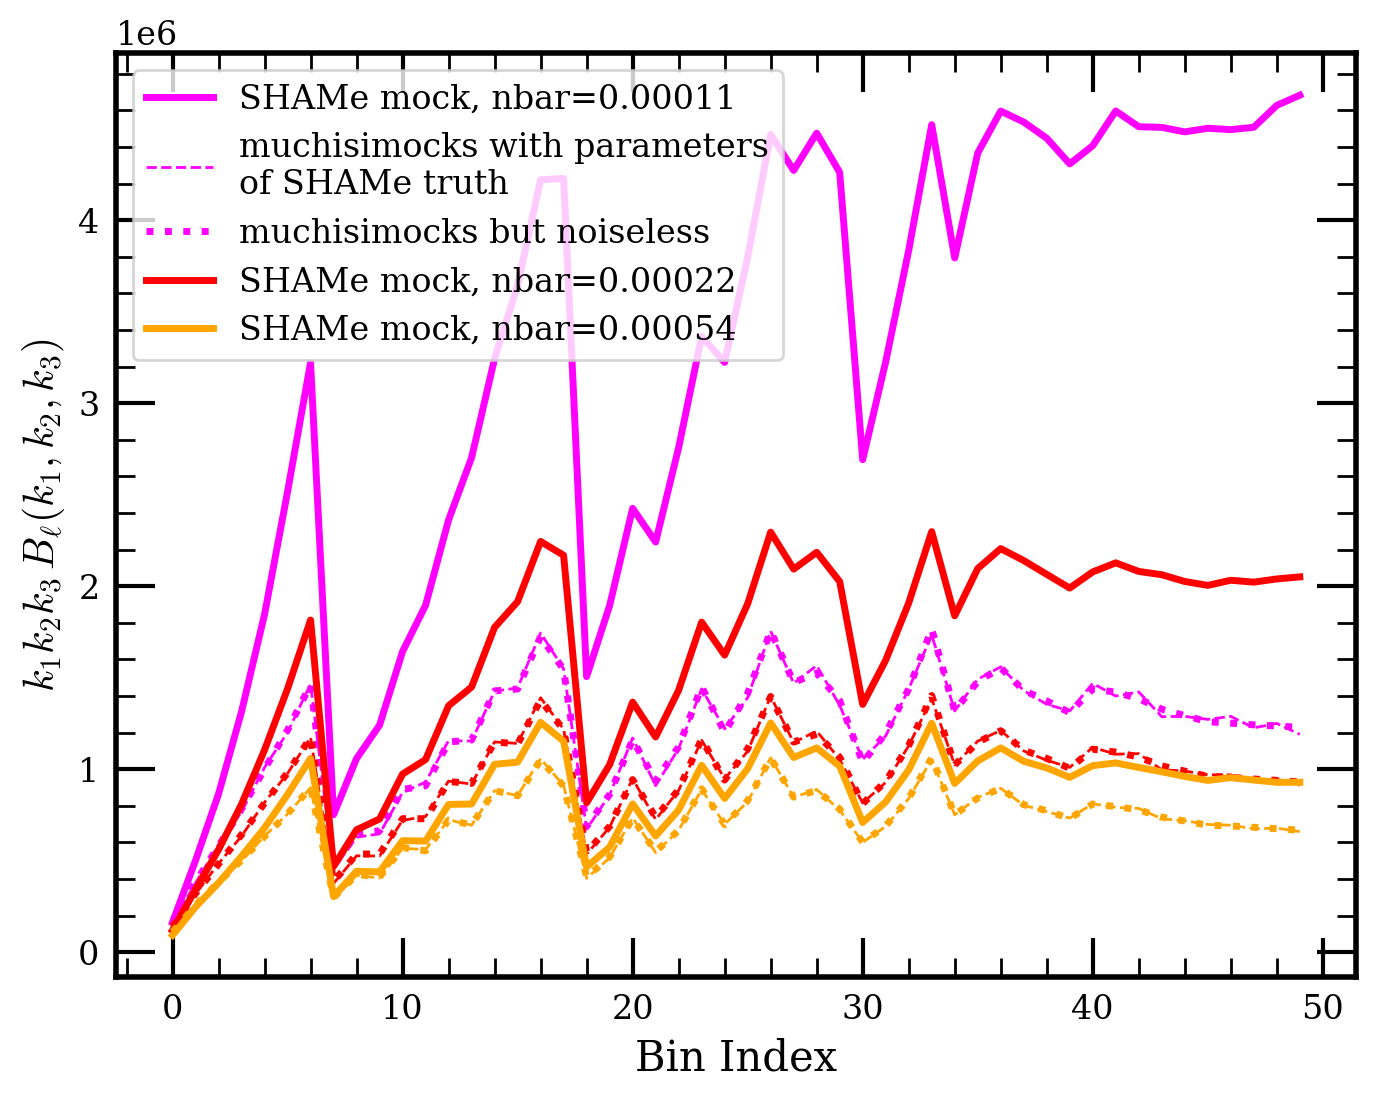

In [21]:
plt.figure(figsize=(8,6))

# ks & norm same for all
k123 = bspec.get_ks()
weight = k123.prod(axis=0)

norm = n_grid**3
norm_mock = n_grid_mock**3
print(norm, norm_mock)

for i, tag_mock in enumerate(tags_mock):
    k_mock = k_mock_arr[i]
    y_mock = y_mock_arr[i]

    label = f'SHAMe mock, nbar={tag_mock.split("nbar")[-1]}'
    if i==0:
        label_muchisimocks = 'muchisimocks with parameters\nof SHAMe truth'
        label_muchisimocks_noiseless = 'muchisimocks but noiseless'
    else:
        label_muchisimocks = None
        label_muchisimocks_noiseless = None
    plt.plot(y_mock[1], color=colors[i], label=label)
    plt.plot(norm**3 * weight*bk_corr_arr[i]['b0'], color=colors[i], ls='--', lw=1, label=label_muchisimocks)
    plt.plot(norm**3 * weight*bk_corr_noiseless_arr[i]['b0'], color=colors[i], lw=2.5, ls=':', label=label_muchisimocks_noiseless)


plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$',fontsize=15)
plt.legend(fontsize=12)
        

### check power spectrum from pos vs grid

In [22]:
tag_mock = '_nbar0.00022' 
nbar = tag_mock.split('nbar')[-1]
dir_cat = '../data/shame_catalogues_to_share/kate'
fn_cat0 = f'{dir_cat}/kate_sham_catalogue_a1.0_par_b_Planck_N3072_L1024_0.00_{nbar}.h5'
fn_catpi = f'{dir_cat}/kate_sham_catalogue_a1.0_par_b_Planck_N3072_L1024_3.14_{nbar}.h5'

data_mode = 'shame'

# Grid and box parameters
box_size_muchisimocks = 1000.0
box_size_mock = 1024.0
n_grid_target = 128
n_grid_mock = utils.round_to_nearest_even(box_size_mock / (box_size_muchisimocks/n_grid_target))

In [23]:
# Load catalog
with h5py.File(fn_cat0, 'r') as cat:
    positions_0 = cat['gal_pos'][:]
    n_galaxies_0 = len(positions_0)

In [24]:
# Load catalog
with h5py.File(fn_catpi, 'r') as cat:
    positions_pi = cat['gal_pos'][:]
    n_galaxies_pi = len(positions_pi)

In [25]:
cosmo = utils.get_cosmo(utils.cosmo_dict_shame)

In [26]:
log_binning=True
normalise_grid=True #??
deconvolve_grid=False
interlacing=False
deposit_method='cic'
correct_grid=False
n_threads=8

# fixing these here to ensure binning is same for all stats computed!
k_min = 0.01
k_max = 0.4
n_bins = 30
    
    
args_power = {
    # "grid1": None,
    # "grid2": None,
    "normalise_grid1": normalise_grid, #default: False
    "normalise_grid2": normalise_grid, #default: False
    "deconvolve_grid1": deconvolve_grid, #default: False
    "deconvolve_grid2": deconvolve_grid, #default: False
    #"ngrid": n_grid_mock,
    "box": box_size_mock,
    "mass1": None,
    "mass2": None,
    "interlacing": interlacing, #default: True
    "deposit_method": deposit_method, #default: "tsc",
    "log_binning": log_binning,
    #"pk_lt": None,
    "kmin": k_min,
    "kmax": k_max,
    "nbins": n_bins,
    "correct_grid": correct_grid,
    "zspace": False,
    "cosmology": cosmo,
    #"pmulti_interp": "polyfit",
    "nthreads": n_threads,
    #"compute_correlation": False, #default: True
    #"compute_power2d": False, #default: True
    "folds": 1,
    #"totalmass1": None,
    #"totalmass2": None,
    #"jack_error": False,
    #"n_jack": None
}

pknbody_dict = {
    #'ngrid': n_grid_mock,
    'min_k': k_min,
    'log_binning': log_binning,
    'log_binning_kmax': k_max,
    'log_binning_nbins': n_bins,
    'interlacing': interlacing,
    'depmethod': deposit_method,
    'correct_grid': correct_grid,
    'folds': 1 #default
}
bacco.configuration.update({'number_of_threads': n_threads})
bacco.configuration.update({'pknbody': pknbody_dict})
bacco.configuration.update({'pk' : {'maxk' : k_max}})
#bacco.configuration.update({'scaling' : {'disp_ngrid' : n_grid_mock}})

In [27]:
pk_obj_pos = bacco.statistics.compute_crossspectrum(
        pos1=positions_0,
        pos2=positions_0,
        **args_power)

2025-11-27 10:33:38,404 bacco.statistics : Computing the cross power spectrum with ngrid=256 and interlacing=False
2025-11-27 10:33:39,797 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=False
2025-11-27 10:33:39,798 bacco.statistics : starting deposit 1
2025-11-27 10:33:39,816 bacco.statistics :  mesh done in 0.0197 s
2025-11-27 10:33:39,817 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=False
2025-11-27 10:33:39,817 bacco.statistics : starting deposit 1
2025-11-27 10:33:39,836 bacco.statistics :  mesh done in 0.0186 s


bacco.mesh : boxsize=1024.000000 ngrid=256, nthreads=8, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 64.0 Mb
bacco.mesh : binning of 236223 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.mesh : boxsize=1024.000000 ngrid=256, nthreads=8, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 64.0 Mb
bacco.mesh : binning of 236223 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 1024.000000; ngrid 256; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 236223 (grid1) 236223 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.087103 sec
bacco.power : Counting modes


2025-11-27 10:33:40,061 bacco.statistics :  ...done in 1.66 s


bacco.power : done counting modes in 0.095254 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000271 secs
bacco.power : Deallocating arrays


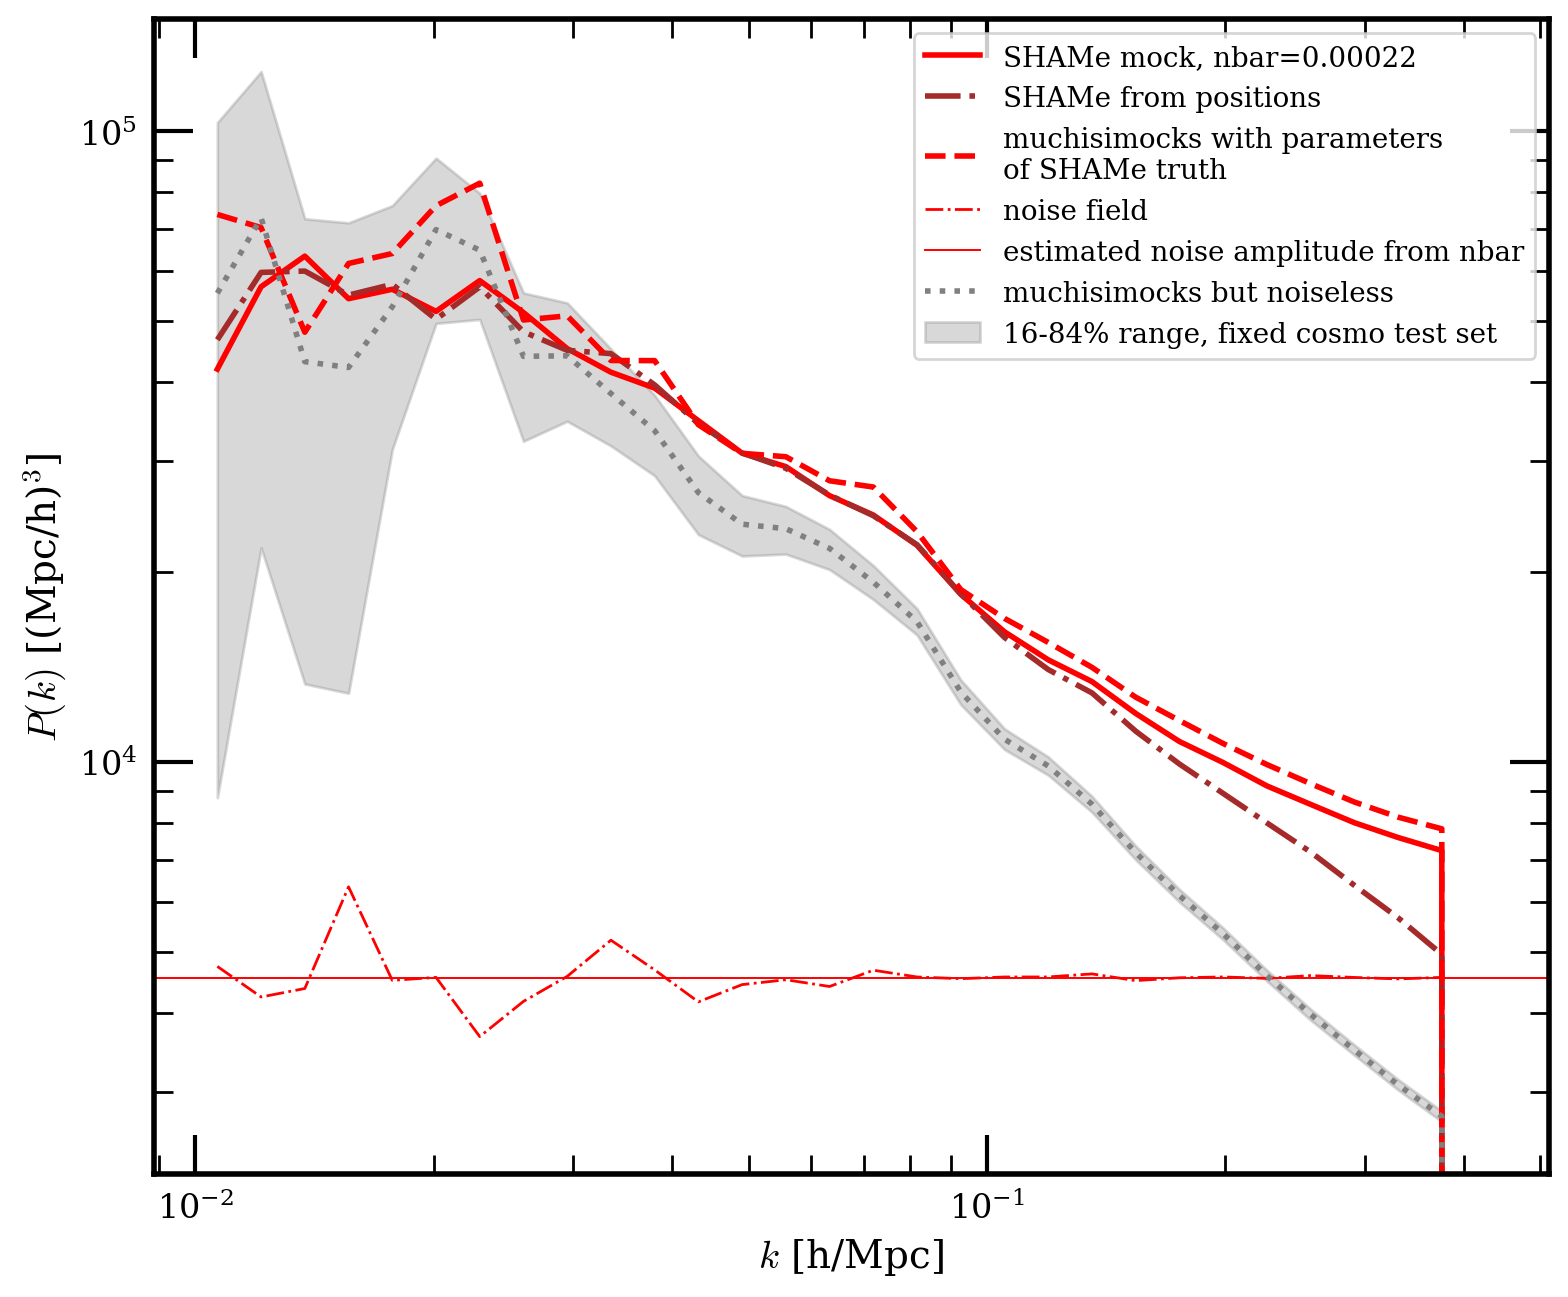

In [28]:
plt.figure(figsize=(9,7.5))
colors = ['magenta', 'red', 'orange']
i = 1  # for nbar0.00022

k_mock = k_mock_arr[i]
y_mock = y_mock_arr[i]
pk_obj = pk_obj_arr[i]

label = f'SHAMe mock, nbar={tag_mock.split("nbar")[-1]}'
plt.plot(k_mock[0], y_mock[0], color=colors[i], label=label, lw=2)
# TODO careful this is just for first mock! 
plt.plot(pk_obj_pos['k'], pk_obj_pos['pk'], color='brown', label='SHAMe from positions', lw=2, alpha=1, ls='-.')

label_muchisimocks = 'muchisimocks with parameters\nof SHAMe truth'
label_noise = 'noise field'
label_noiseamp = 'estimated noise amplitude from nbar'
plt.plot(pk_obj['k'], pk_obj['pk'], color=colors[i], ls='--', label=label_muchisimocks, lw=2)

plt.plot(pk_obj_noise_arr[i]['k'], pk_obj_noise_arr[i]['pk'], color=colors[i], ls='-.', label=label_noise, lw=1)

plt.axhline(noise_amp_arr[i], color=colors[i], ls='-', lw=0.7, label=label_noiseamp)
    
#plt.plot(pk_obj_pos['k'], pk_obj_pos['pk']/n_grid_mock**6, color=colors[i], label='from positions', lw=1.4, alpha=0.5)

plt.plot(pk_obj_noiseless['k'], pk_obj_noiseless['pk'], color='grey', ls=':', label='muchisimocks but noiseless', lw=2)
plt.fill_between(pk_obj_noiseless['k'][mask], pk_obj_noiseless['pk'][mask] - err_lo, pk_obj_noiseless['pk'][mask] + err_hi, color='grey', alpha=0.3, label=r'16-84% range, fixed cosmo test set')
plt.xscale('log')
plt.yscale('log') 
plt.xlabel(r'$k$ [h/Mpc]', fontsize=14)
plt.ylabel(r'$P(k)$ [(Mpc/h)$^3$]', fontsize=14)

plt.legend(fontsize=10, loc='upper right')

## Try bispectrum noise model

In [29]:
from scipy.interpolate import interp1d

i = 1
P_interp_log = interp1d(np.log(pk_obj_arr[i]['k']), np.log(pk_obj_arr[i]['pk']), kind='linear',
                       bounds_error=False, fill_value='extrapolate')

def P_interp_loglog(k):
    return np.exp(P_interp_log(np.log(k)))

/tmp/ipykernel_1010509/1022027459.py:4: RuntimeWarning: divide by zero encountered in log
  P_interp_log = interp1d(np.log(pk_obj_arr[i]['k']), np.log(pk_obj_arr[i]['pk']), kind='linear',


In [30]:
eps0_b = 0.1
eps1_b = 0.1
eps2_b = -0.9
eps3_b = 1
eps4_b = 1

nbar = float(tags_mock[i].split('nbar')[-1])
k1, k2, k3 = k123
fP1, fP2, fP3 = P_interp_loglog(k1), P_interp_loglog(k2), P_interp_loglog(k3)
    
term0 = (1/nbar**2) * (1 + eps0_b + eps1_b*(k1**2 + k2**2 + k3**2))
term1 = (1 + eps2_b)/nbar * (fP1 + fP2 + fP3)
term2 = eps3_b/nbar * (fP1*(k2**2 + k3**2) + fP2*(k1**2 + k3**2) + fP3*(k1**2 + k2**2))
term3 = eps4_b/nbar * (fP1*k1**2 + fP2*k2**2 + fP3*k3**2)

bispec_noise = term0 + term1 + term2 + term3
bispec_noise /= n_grid**9  # to match normalization of bispec from compute_bispectrum

In [31]:
# ks & norm same for all
k123 = bspec.get_ks()
weight = k123.prod(axis=0)

norm = n_grid**3
norm_mock = n_grid_mock**3

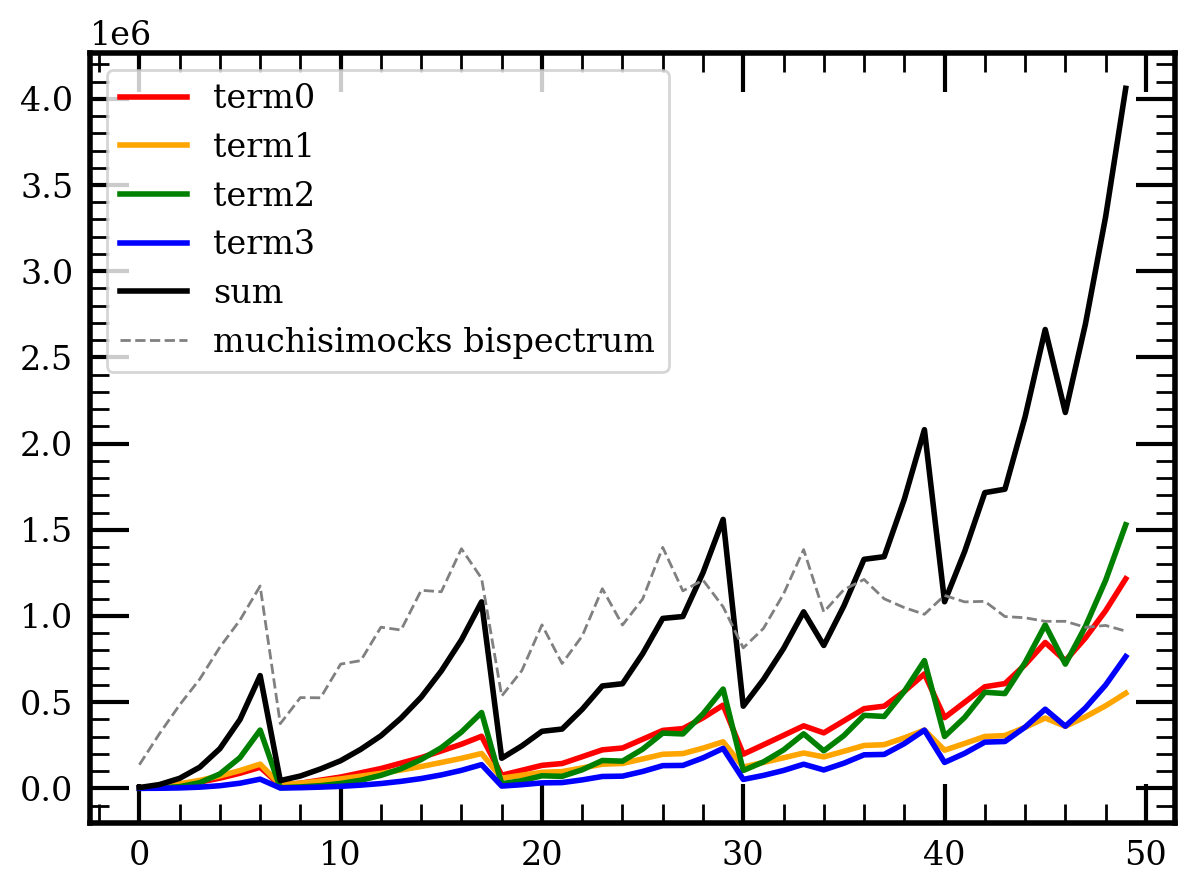

In [32]:
plt.figure(figsize=(7,5))

plt.plot(norm**3 * weight*term0/n_grid**9, color='red', ls='-', lw=2, label='term0')
plt.plot(norm**3 * weight*term1/n_grid**9, color='orange', ls='-', lw=2, label='term1')
plt.plot(norm**3 * weight*term2/n_grid**9, color='green', ls='-', lw=2, label='term2')
plt.plot(norm**3 * weight*term3/n_grid**9, color='blue', ls='-', lw=2, label='term3')
plt.plot(norm**3 * weight*(term0 + term1 + term2 + term3)/n_grid**9, color='black', lw=2, label='sum')
#plt.plot(bispec_noise, color='black', lw=2, label='sum')
i = 1
plt.plot(norm**3 * weight*bk_corr_arr[i]['b0'], color='grey', ls='--', lw=1, label='muchisimocks bispectrum')
plt.legend(fontsize=12)

In [33]:
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import numpy as np

def fit_bispectrum_noise_model(bispectrum_data, bispectrum_mock_noiseless, k123, pk_obj, nbar, n_grid, 
                               terms_to_include=[0, 1, 2, 3], initial_eps=None, method='least_squares'):
    """
    Fit eps parameters for bispectrum noise model.
    terms_to_include: 0=term0(eps0,eps1), 1=term1(eps2), 2=term2(eps3), 3=term3(eps4)
    """
    # Power spectrum interpolation
    P_interp_log = interp1d(np.log(pk_obj['k']), np.log(pk_obj['pk']), 
                           kind='linear', bounds_error=False, fill_value='extrapolate')
    P_interp_loglog = lambda k: np.exp(P_interp_log(np.log(k)))
    
    k1, k2, k3 = k123
    fP1, fP2, fP3 = P_interp_loglog(k1), P_interp_loglog(k2), P_interp_loglog(k3)
    weight, norm = k123.prod(axis=0), n_grid**3
    
    # Parameter mapping: term0 needs 2 params, others need 1
    param_count = 2 if 0 in terms_to_include else 0
    param_count += sum(1 for i in [1, 2, 3] if i in terms_to_include)

    def bispectrum_noise_model(eps_params):
        # Map parameters to eps values
        idx = 0
        eps = [0] * 5  # [eps0_b, eps1_b, eps2_b, eps3_b, eps4_b]
        if 0 in terms_to_include:
            eps[0], eps[1] = eps_params[idx], eps_params[idx+1]
            idx += 2
        for term_idx, eps_idx in zip([1, 2, 3], [2, 3, 4]):
            if term_idx in terms_to_include:
                eps[eps_idx] = eps_params[idx]
                idx += 1
        
        # Calculate terms
        terms = [
            (1/nbar**2) * (1 + eps[0] + eps[1]*(k1**2 + k2**2 + k3**2)), # shot noise
            (1 + eps[2])/nbar * (fP1 + fP2 + fP3), # shot noise x P(k)
            eps[3]/nbar * (fP1*(k2**2 + k3**2) + fP2*(k1**2 + k3**2) + fP3*(k1**2 + k2**2)), # higher order
            eps[4]/nbar * (fP1*k1**2 + fP2*k2**2 + fP3*k3**2) # higher order
        ]
        
        return sum(terms[i] for i in terms_to_include) / n_grid**9
    
    def objective(eps_params):
        bispec_noise = bispectrum_noise_model(eps_params)
        model = norm**3 * weight * (bispectrum_mock_noiseless + bispec_noise)
        if method == 'least_squares':
            return np.sum((bispectrum_data - model)**2)
        elif method == 'chi_squared':
            return np.sum(((bispectrum_data - model) / (np.abs(bispectrum_data) * 0.1))**2)
        else:
            raise ValueError("method must be 'least_squares' or 'chi_squared'")
    
    # Optimization
    initial_eps = initial_eps or [1.0] * param_count
    result = minimize(objective, initial_eps, method='BFGS')
    
    # Return results
    model_bispec = bispectrum_noise_model(result.x)
    return {
        'eps_fitted': result.x,
        'terms_included': terms_to_include,
        'model_bispectrum': model_bispec,
        'chi_squared': np.sum((bispectrum_data - model_bispec)**2),
        'success': result.success
    }

# Usage
i = 1
nbar = float(tags_mock[i].split('nbar')[-1])

fit_term0 = fit_bispectrum_noise_model(y_mock_arr[i][1], bk_corr_noiseless_arr[i]['b0'], 
                                       k123, pk_obj_arr[i], nbar, n_grid, [0])
fit_term01 = fit_bispectrum_noise_model(y_mock_arr[i][1], bk_corr_noiseless_arr[i]['b0'], 
                                        k123, pk_obj_arr[i], nbar, n_grid, [0, 1])
fit_termsall = fit_bispectrum_noise_model(y_mock_arr[i][1], bk_corr_noiseless_arr[i]['b0'], 
                                     k123, pk_obj_arr[i], nbar, n_grid)

print("Term0 only:", fit_term0['eps_fitted'])
print("Term0+1:", fit_term01['eps_fitted']) 
print("All terms:", fit_termsall['eps_fitted'])

Term0 only: [ 3.63969426 -9.01992613]
Term0+1: [-1.10108588 -4.82017712 -0.40354669]
All terms: [  9.16698501  72.5281806   -1.01804898   1.37838793 -57.45594591]


/tmp/ipykernel_1010509/18912126.py:12: RuntimeWarning: divide by zero encountered in log
  P_interp_log = interp1d(np.log(pk_obj['k']), np.log(pk_obj['pk']),
/tmp/ipykernel_1010509/18912126.py:12: RuntimeWarning: divide by zero encountered in log
  P_interp_log = interp1d(np.log(pk_obj['k']), np.log(pk_obj['pk']),
/tmp/ipykernel_1010509/18912126.py:12: RuntimeWarning: divide by zero encountered in log
  P_interp_log = interp1d(np.log(pk_obj['k']), np.log(pk_obj['pk']),


In [39]:
eps0_b, eps1_b, eps2_b = 0,0,0
term0 = (1/nbar**2) * (1 + eps0_b + eps1_b*(k1**2 + k2**2 + k3**2))
term1 = (1 + eps2_b)/nbar * (fP1 + fP2 + fP3)

bispec_noise0s = term0 + term1
bispec_noise0s /= n_grid**9  # to match normalization of bispec from compute_bispectrum

2097152 2299968


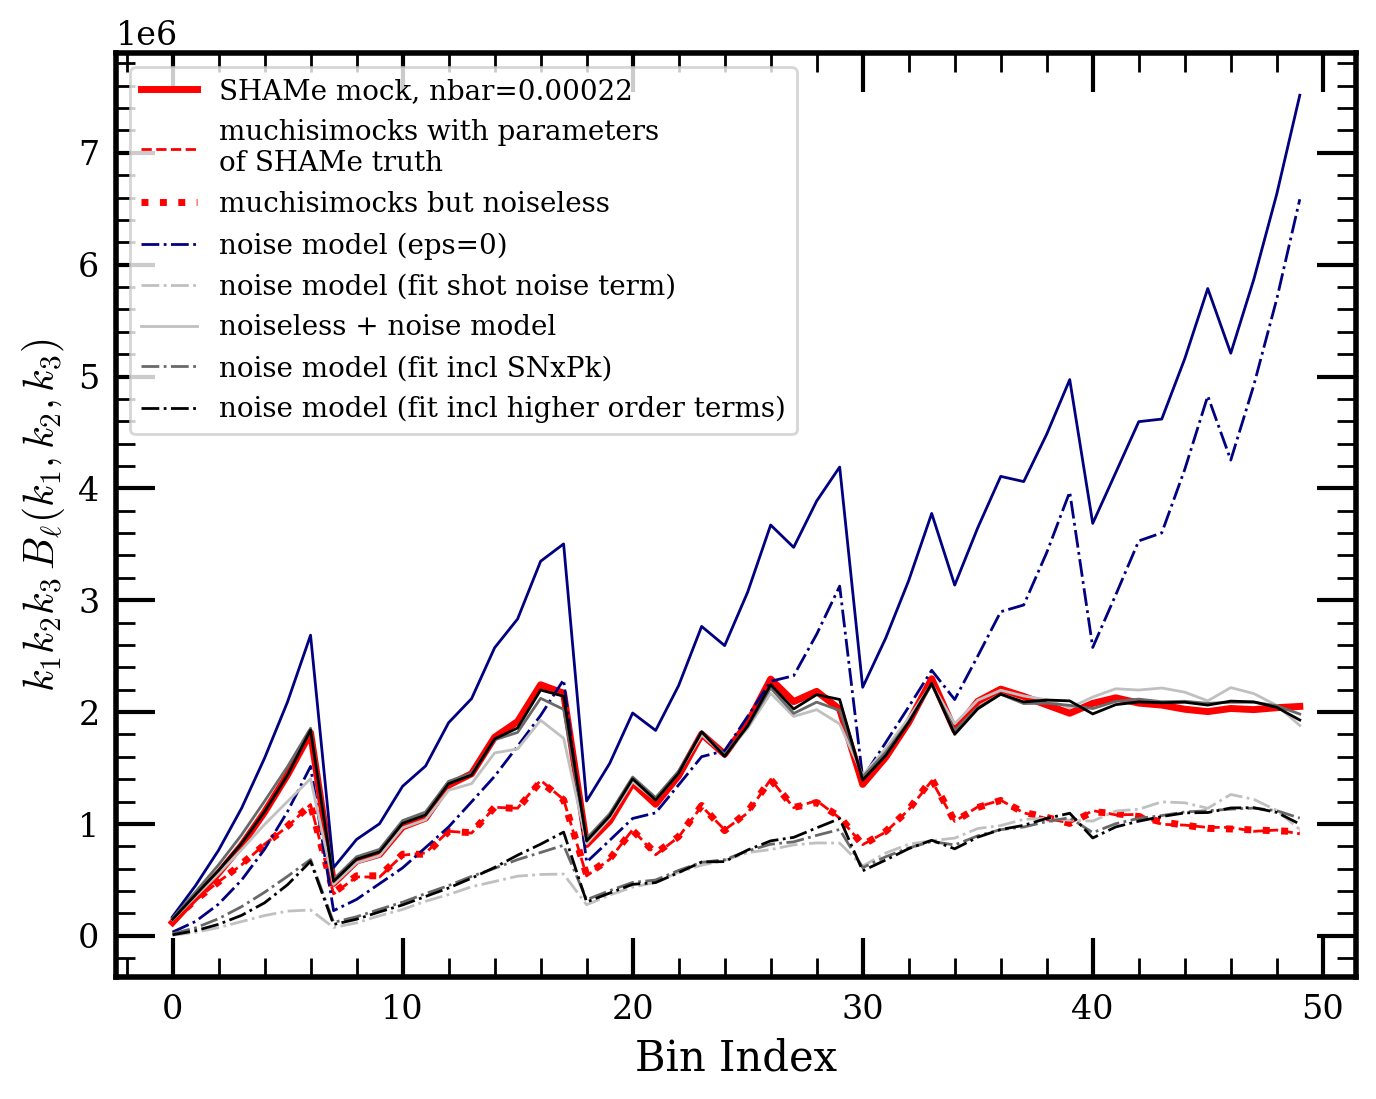

In [40]:
plt.figure(figsize=(8,6))

# ks & norm same for all
k123 = bspec.get_ks()
weight = k123.prod(axis=0)

norm = n_grid**3
norm_mock = n_grid_mock**3
print(norm, norm_mock)

i = 1
k_mock = k_mock_arr[i]
y_mock = y_mock_arr[i]

bk_corr = bk_corr_arr[i]

label = f'SHAMe mock, nbar={tag_mock.split("nbar")[-1]}'
label_muchisimocks = 'muchisimocks with parameters\nof SHAMe truth'
label_muchisimocks_noiseless = 'muchisimocks but noiseless'

plt.plot(y_mock[1], color=colors[i], label=label)
plt.plot(norm**3 * weight*bk_corr['b0'], color=colors[i], ls='--', lw=1, label=label_muchisimocks)
plt.plot(norm**3 * weight*bk_corr_noiseless_arr[i]['b0'], color=colors[i], lw=2.5, ls=':', label=label_muchisimocks_noiseless)


plt.plot(norm**3 * weight*bispec_noise0s, color='navy', ls='-.', lw=1,
         label='noise model (eps=0)')
plt.plot(norm**3 * weight*(bk_corr_noiseless_arr[i]['b0']+bispec_noise0s),
         color='navy', ls='-', lw=1, 
         #label='noiseless + noise model (fit incl higher order terms)'
         )

plt.plot(norm**3 * weight*fit_term0['model_bispectrum'], color='silver', ls='-.', lw=1,
         label='noise model (fit shot noise term)')
plt.plot(norm**3 * weight*(bk_corr_noiseless_arr[i]['b0']+fit_term0['model_bispectrum']), 
         color='silver', ls='-', lw=1, 
         label='noiseless + noise model')

plt.plot(norm**3 * weight*fit_term01['model_bispectrum'], color='dimgrey', ls='-.', lw=1,
         label='noise model (fit incl SNxPk)')
plt.plot(norm**3 * weight*(bk_corr_noiseless_arr[i]['b0']+fit_term01['model_bispectrum']),
         color='dimgrey', ls='-', lw=1, 
         #label='noiseless + noise model (fit incl SNxPk)'
         )

plt.plot(norm**3 * weight*fit_termsall['model_bispectrum'], color='black', ls='-.', lw=1,
         label='noise model (fit incl higher order terms)')
plt.plot(norm**3 * weight*(bk_corr_noiseless_arr[i]['b0']+fit_termsall['model_bispectrum']),
         color='black', ls='-', lw=1, 
         #label='noiseless + noise model (fit incl higher order terms)'
         )



#plt.plot(norm**3 * weight*bispec_noise, color='grey', ls='-.', lw=2, label='bispectrum noise model')

plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$',fontsize=15)
plt.legend(fontsize=10)
        

## Try Rubira & Schmidt approach

In [3]:
data_mode_test = 'shame'
tag_mock = '_nbar0.00022'
tag_data_train = None # this is used for mask; we get it below 
statistics = ['pk', 'bispec']
k_mock, y_mock, y_err_mock = data_loader.load_data_ood(data_mode_test, statistics, tag_mock, tag_data=tag_data_train)

Loaded pk with shape (30,)
Loaded pk data with shape (30,)
No tag_data provided, so not masking data
Loaded bispec with shape (50,)
Loaded bispec data with shape (50,)
No tag_data provided, so not masking data


In [4]:
dir_mocks = f'/scratch/kstoreyf/muchisimocks/muchisimocks_lib_ood/shame'
subdir_prefix = 'mock'
idx_mock = 0
fn_fields = f'{dir_mocks}/{subdir_prefix}{idx_mock}/bias_fields_eul_deconvolved_{idx_mock}.npy'
bias_terms_eul = np.load(fn_fields)

In [5]:
param_dict = data_loader.load_params_ood('shame', tag_mock)
cosmo = utils.get_cosmo(param_dict)
bias_vector = [param_dict[name] for name in utils.biasparam_names_ordered]

In [6]:
bias_vector

[0.47410742, 0.03175373, -0.16940883, -0.82443643]

In [7]:
n_grid = 128
rng = np.random.default_rng(seed=42)
noise_field_unit = rng.standard_normal((n_grid, n_grid, n_grid))

In [8]:
n_grid_orig = 512
bs = np.concatenate(([1.0], bias_vector))
tracer_field_ff_det = np.sum([bs[i] * bias_terms_eul[i] for i in range(len(bs))], axis=0) / n_grid_orig**3

In [9]:
#As_noise = [0.8, 0.5, 0.0, 0.0, 0.0]  # A_noise parameters
As_noise = bs * 1.0
tracer_field_ff_noise = np.sum([As_noise[i] * noise_field_unit * bias_terms_eul[i] for i in range(len(As_noise))], axis=0) / n_grid_orig**3

In [10]:
tracer_field_ff = tracer_field_ff_det + tracer_field_ff_noise

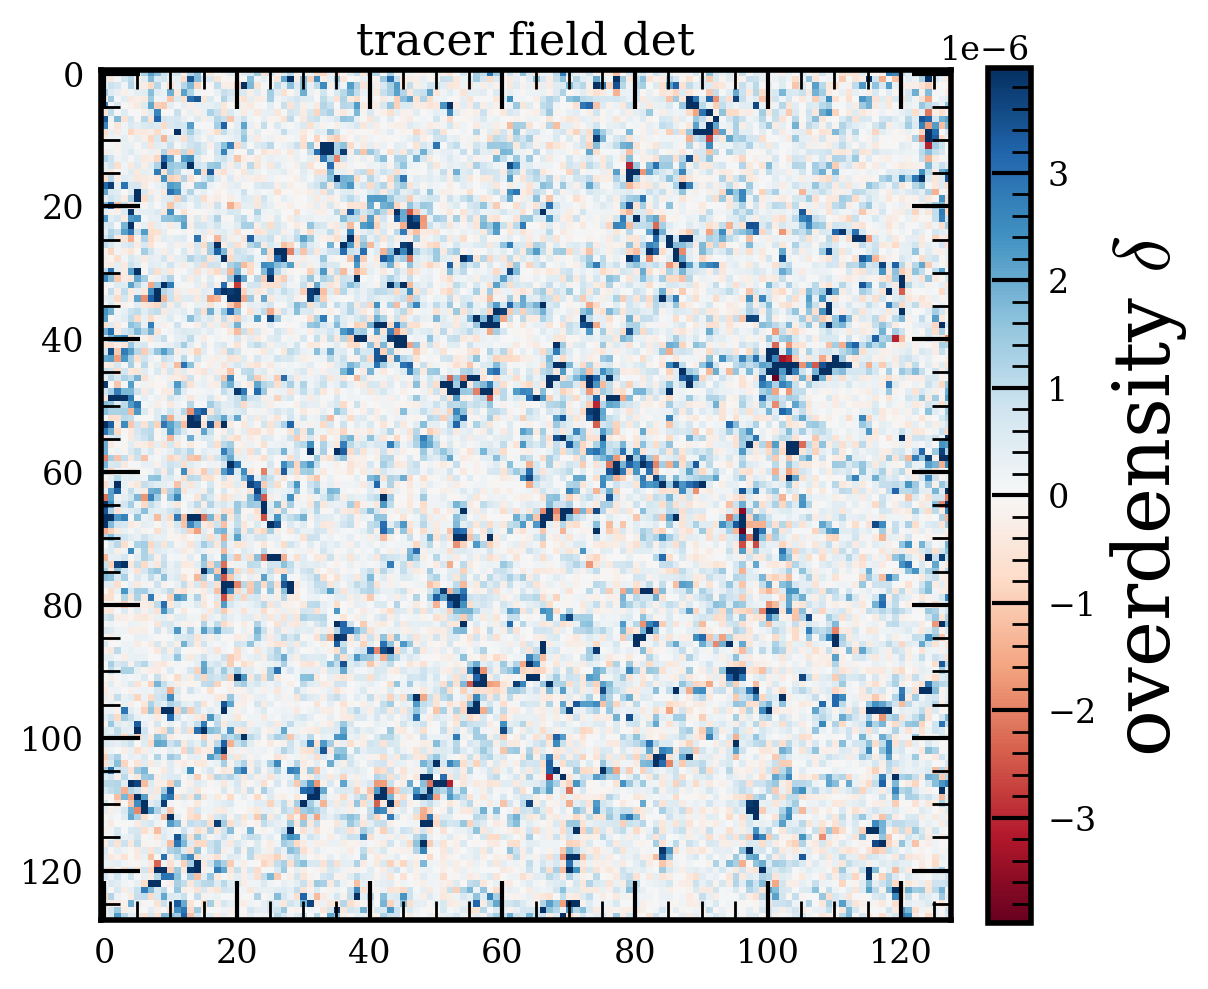

In [11]:
plotter.plot_overdensity_field(tracer_field_ff_det, title='tracer field det')

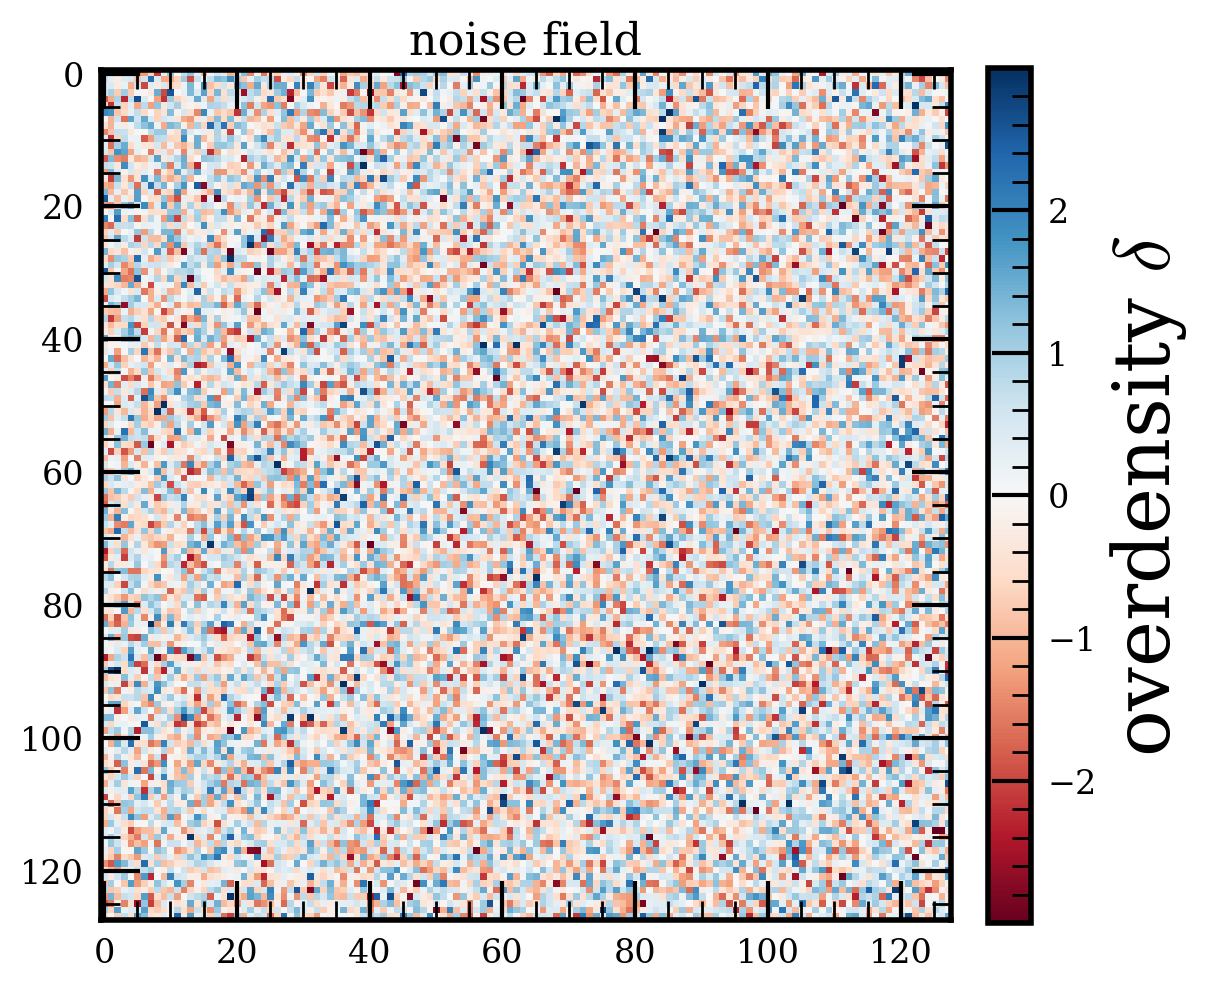

In [27]:
plotter.plot_overdensity_field(noise_field_unit, title='noise field')

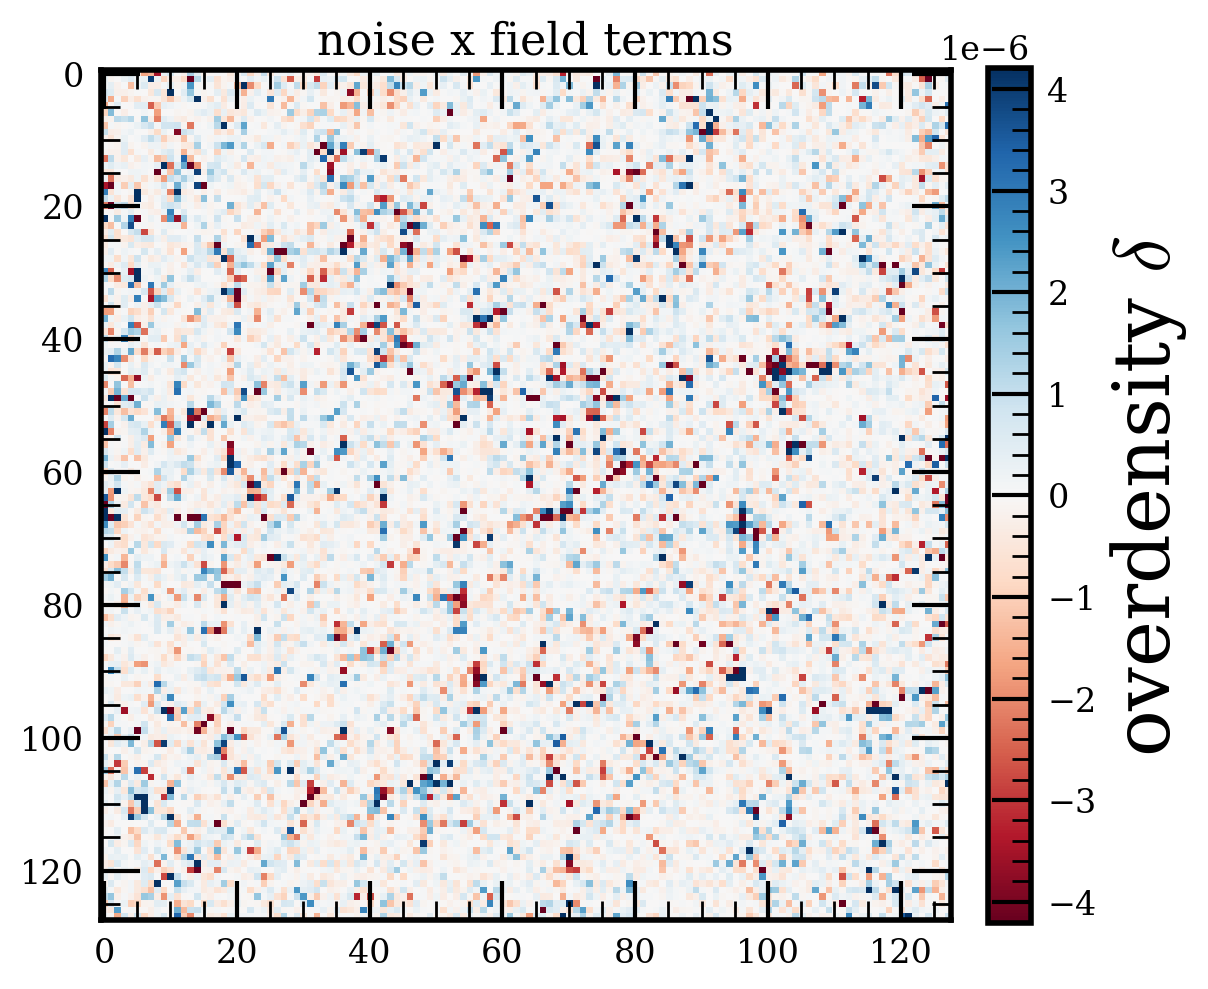

In [28]:
plotter.plot_overdensity_field(tracer_field_ff_noise, title='noise x field terms')

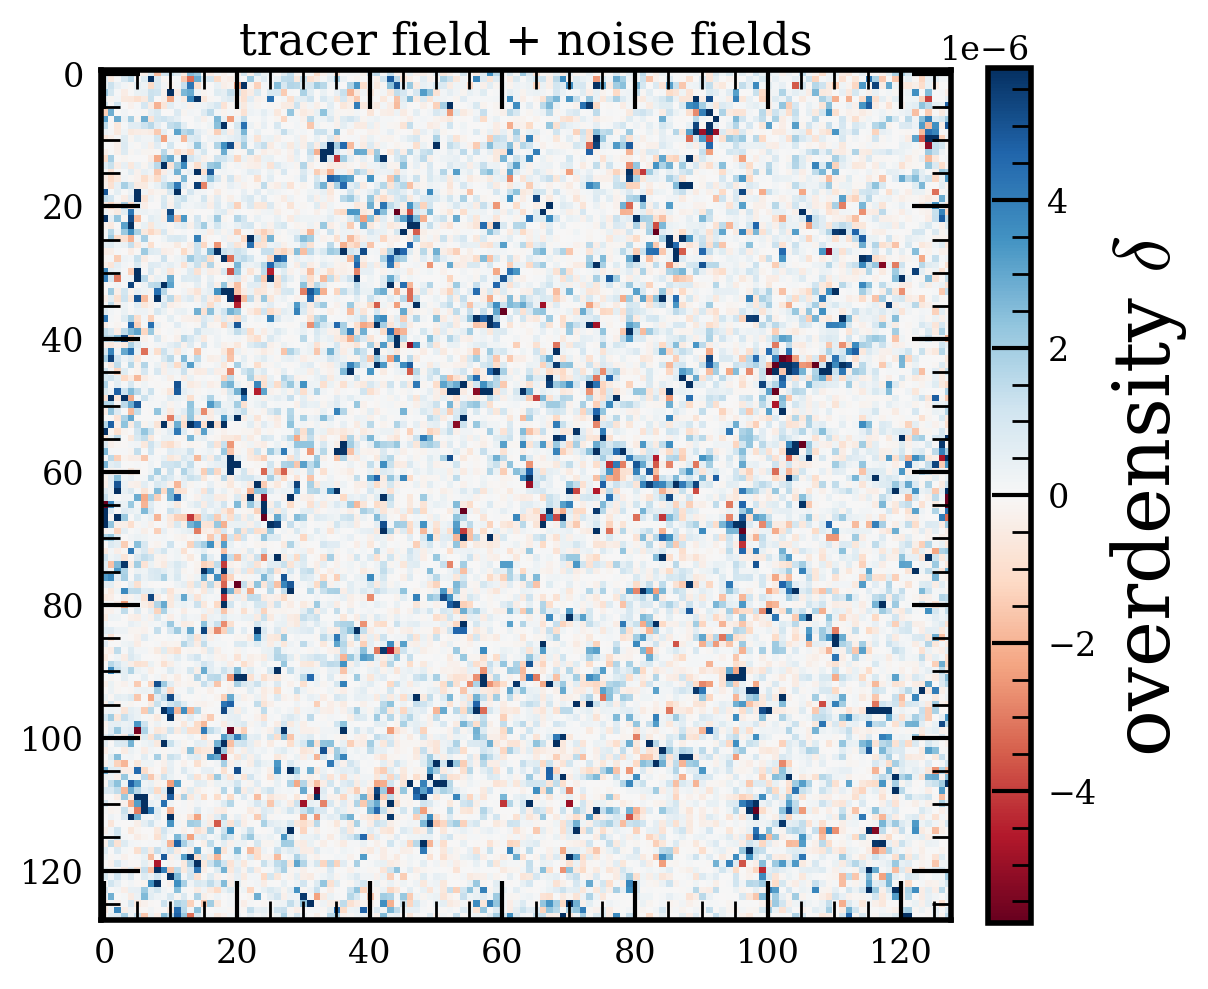

In [29]:
plotter.plot_overdensity_field(tracer_field_ff, title='tracer field + noise fields')

In [15]:
box_size = 1000.0

In [16]:
pk_obj_ff_det = cs.compute_pk(tracer_field_ff_det, cosmo, box_size,
                               n_threads=1, fn_stat=None)

Computing pk, using n_grid =  128


2025-12-01 23:39:18,005 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


2025-12-01 23:39:19,723 bacco.statistics :  ...done in 1.72 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.017226 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.043099 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000124 secs
bacco.power : Deallocating arrays


In [17]:
pk_obj_ff_noise = cs.compute_pk(tracer_field_ff_noise, cosmo, box_size,
                               n_threads=1, fn_stat=None)

Computing pk, using n_grid =  128


2025-12-01 23:39:20,128 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-12-01 23:39:20,299 bacco.statistics :  ...done in 0.171 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.000391988 (grid1) 0.000391988 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.014206 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.042286 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000127 secs
bacco.power : Deallocating arrays


In [18]:
pk_obj_ff = cs.compute_pk(tracer_field_ff, cosmo, box_size,
                               n_threads=1, fn_stat=None)

Computing pk, using n_grid =  128


2025-12-01 23:39:20,658 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-12-01 23:39:20,790 bacco.statistics :  ...done in 0.132 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00039 (grid1) 1.00039 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.014111 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.042434 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000137 secs
bacco.power : Deallocating arrays


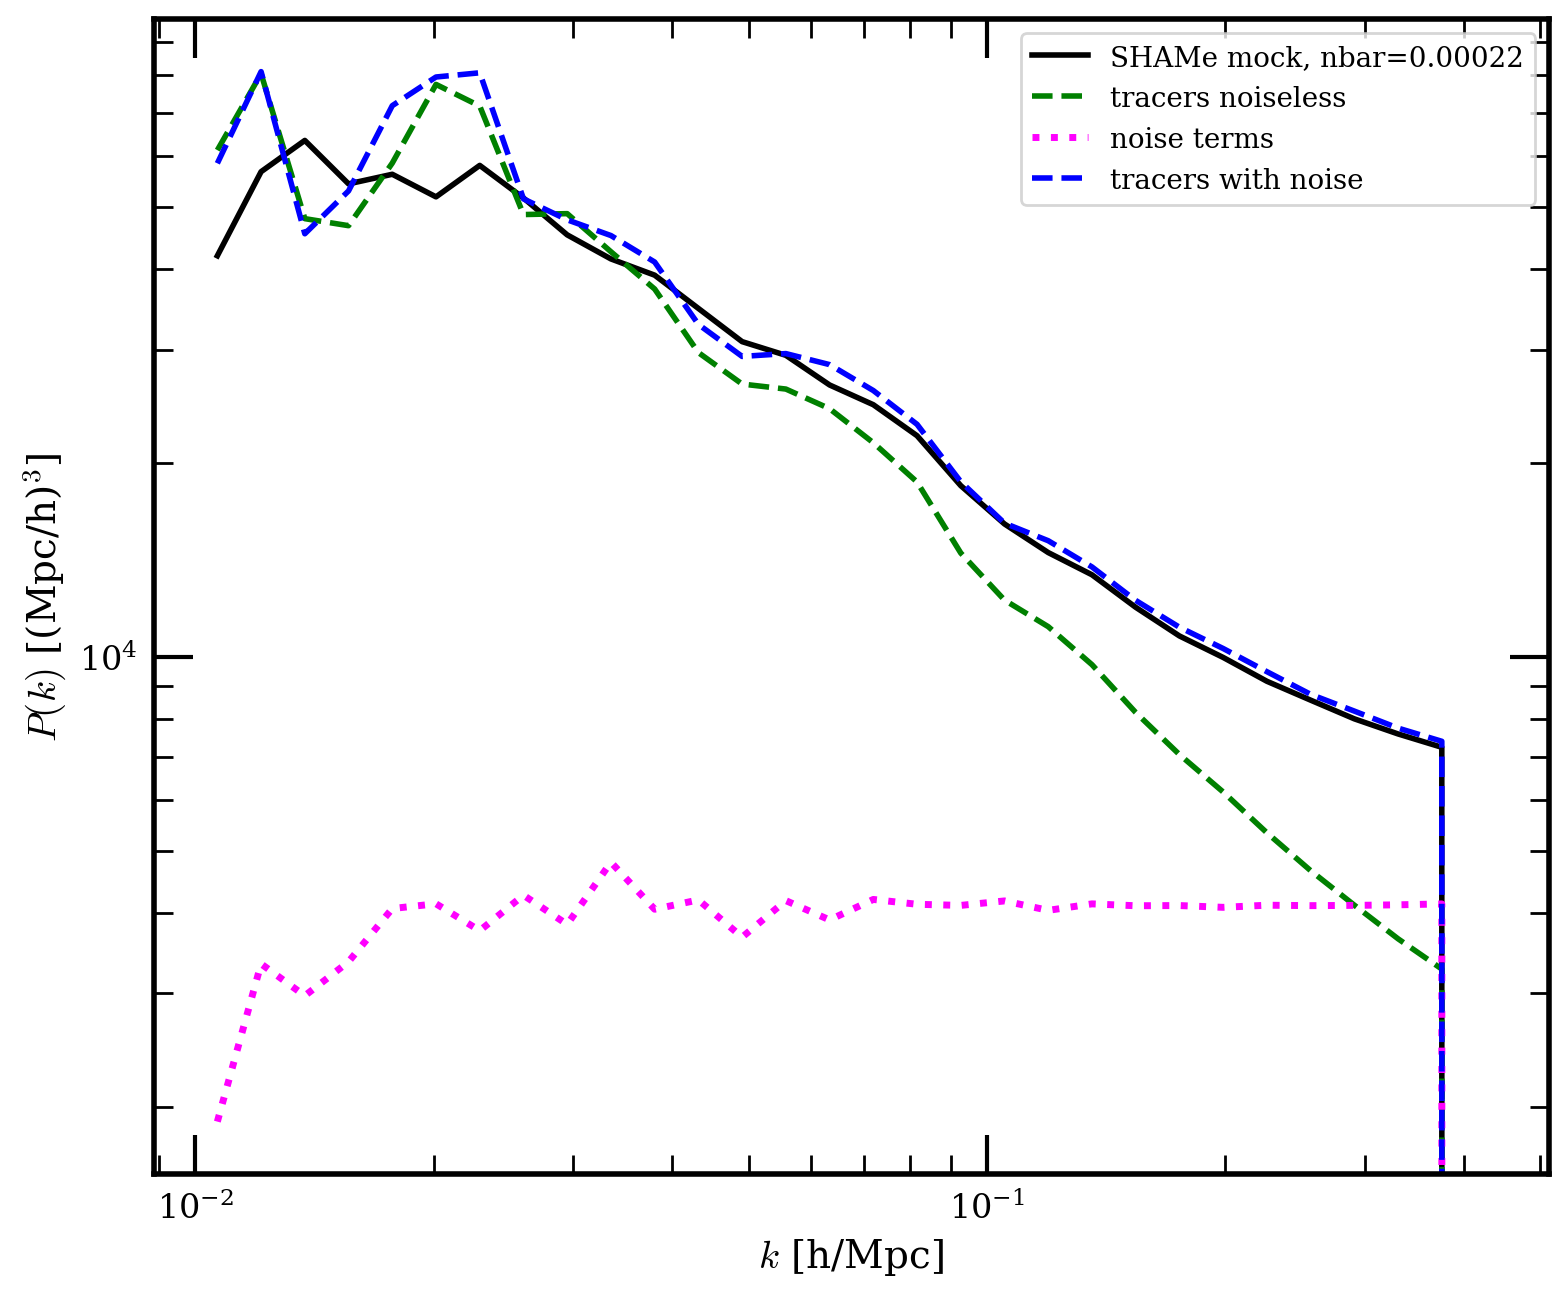

In [19]:
plt.figure(figsize=(9,7.5))
colors = ['magenta', 'red', 'orange']

label = f'SHAMe mock, nbar={tag_mock.split("nbar")[-1]}'
plt.plot(k_mock[0], y_mock[0], color='black', label=label, lw=2)

label_muchisimocks = 'muchisimocks with parameters\nof SHAMe truth'
label_noise = 'noise field'
label_noiseamp = 'estimated noise amplitude from nbar'

plt.plot(pk_obj_ff_det['k'], pk_obj_ff_det['pk'], color='green', ls='--', label='tracers noiseless', lw=2)
plt.plot(pk_obj_ff_noise['k'], pk_obj_ff_noise['pk'], ls=':', color='magenta', label='noise terms')
plt.plot(pk_obj_ff['k'], pk_obj_ff['pk'], color='blue', ls='--', label='tracers with noise', lw=2)


#plt.plot(pk_obj_pos['k'], pk_obj_pos['pk']/n_grid_mock**6, color=colors[i], label='from positions', lw=1.4, alpha=0.5)
#plt.plot(pk_obj_noiseless['k'], pk_obj_noiseless['pk'], color='grey', ls=':', label='muchisimocks but noiseless', lw=2)
#plt.fill_between(pk_obj_noiseless['k'][mask], pk_obj_noiseless['pk'][mask] - err_lo, pk_obj_noiseless['pk'][mask] + err_hi, color='grey', alpha=0.3, label=r'16-84% range, fixed cosmo test set')

plt.xscale('log')
plt.yscale('log') 
plt.xlabel(r'$k$ [h/Mpc]', fontsize=14)
plt.ylabel(r'$P(k)$ [(Mpc/h)$^3$]', fontsize=14)

plt.legend(fontsize=10, loc='upper right')

In [20]:
box_size = 1000.0
n_grid = 128

In [21]:
base = cs.setup_bispsec(box_size, n_grid, n_threads=1)


# Dimensions: [1.00e+03, 1.00e+03, 1.00e+03] Mpc/h
# Center: [0.00e+00, 0.00e+00, 0.00e+00] Mpc/h
# Line-of-sight: global
# Fourier-space grid: [128, 128, 128]
# Fundamental frequency: [0.006, 0.006, 0.006] h/Mpc
# Nyquist frequency: [0.402, 0.402, 0.402] h/Mpc
# Pixel window: none
# Using fftw backend
PolyBin3D setup time: 1.24 s


In [22]:
bspec_ff_noise, bk_corr_ff_noise = cs.compute_bispectrum(base, tracer_field_ff_noise)


Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix


In [23]:
bspec_ff_det, bk_corr_ff_det = cs.compute_bispectrum(base, tracer_field_ff_det)


Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant


Computing degeneracy factor
Computing ideal Fisher matrix


In [24]:
bspec_ff, bk_corr_ff = cs.compute_bispectrum(base, tracer_field_ff)


Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix


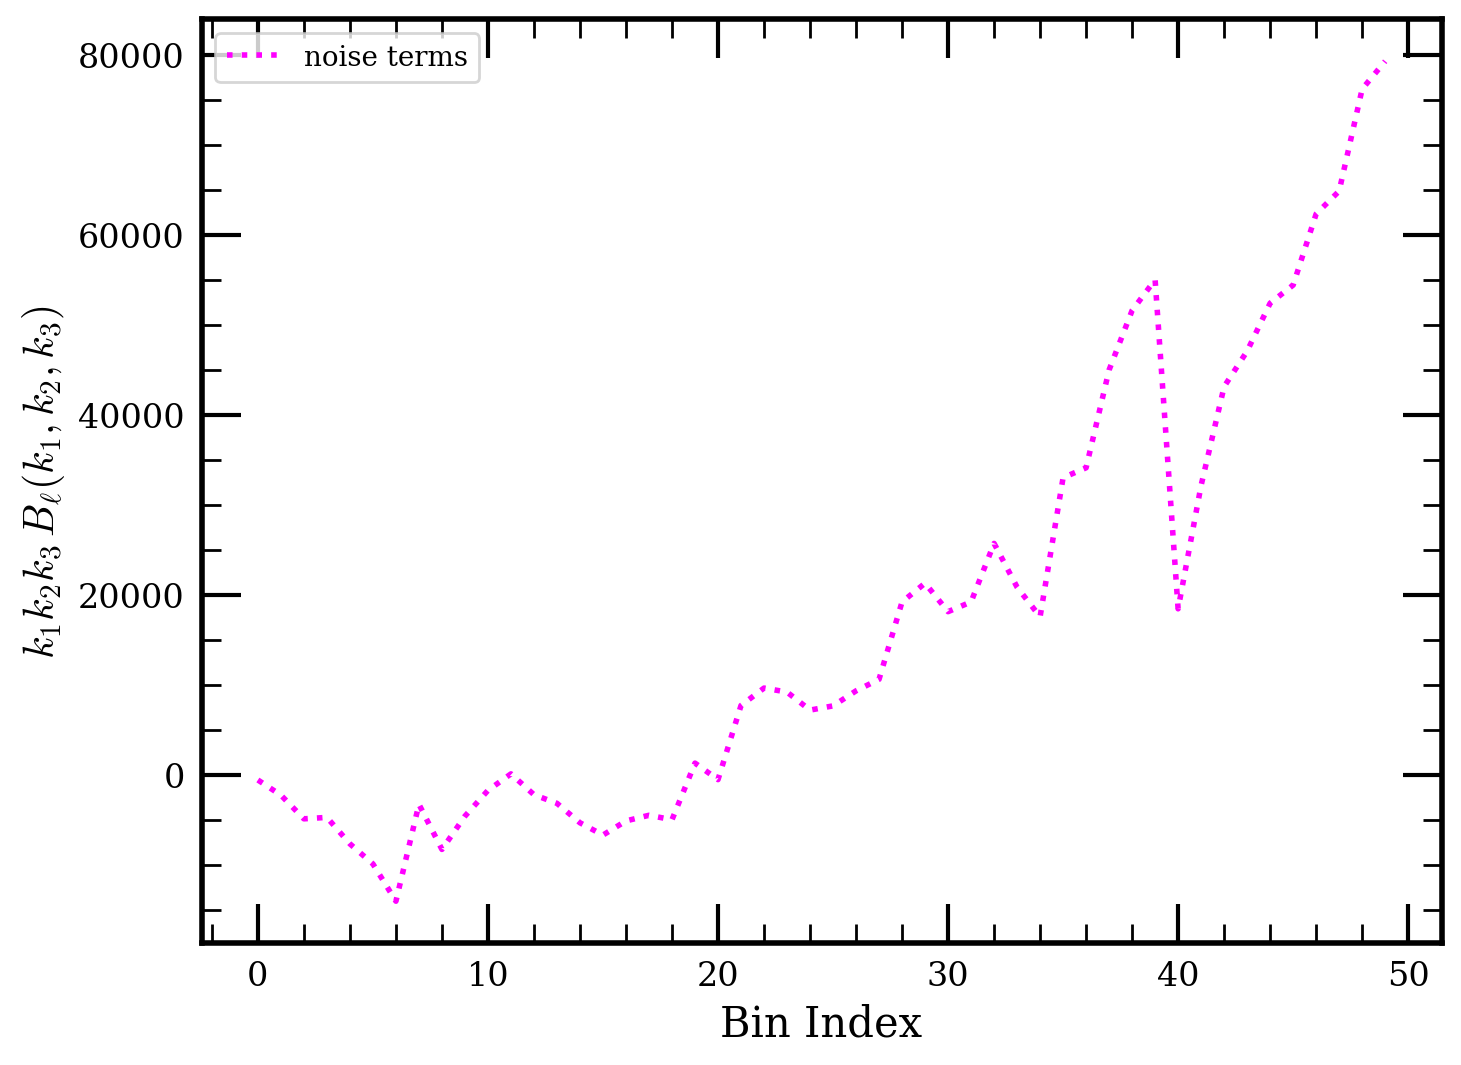

In [25]:
plt.figure(figsize=(8,6))

# ks & norm same for all
k123 = bspec_ff.get_ks()
weight = k123.prod(axis=0)

norm = n_grid**3
#norm_mock = n_grid_mock**3
#print(norm, norm_mock)

label = f'SHAMe mock, nbar={tag_mock.split("nbar")[-1]}'
label_muchisimocks = 'muchisimocks with parameters\nof SHAMe truth'
label_muchisimocks_noiseless = 'muchisimocks but noiseless'

plt.plot(norm**3 * weight*bk_corr_ff_noise['b0'], color='magenta', ls=':', lw=2, label='noise terms')

plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$',fontsize=15)
plt.legend(fontsize=10)
        

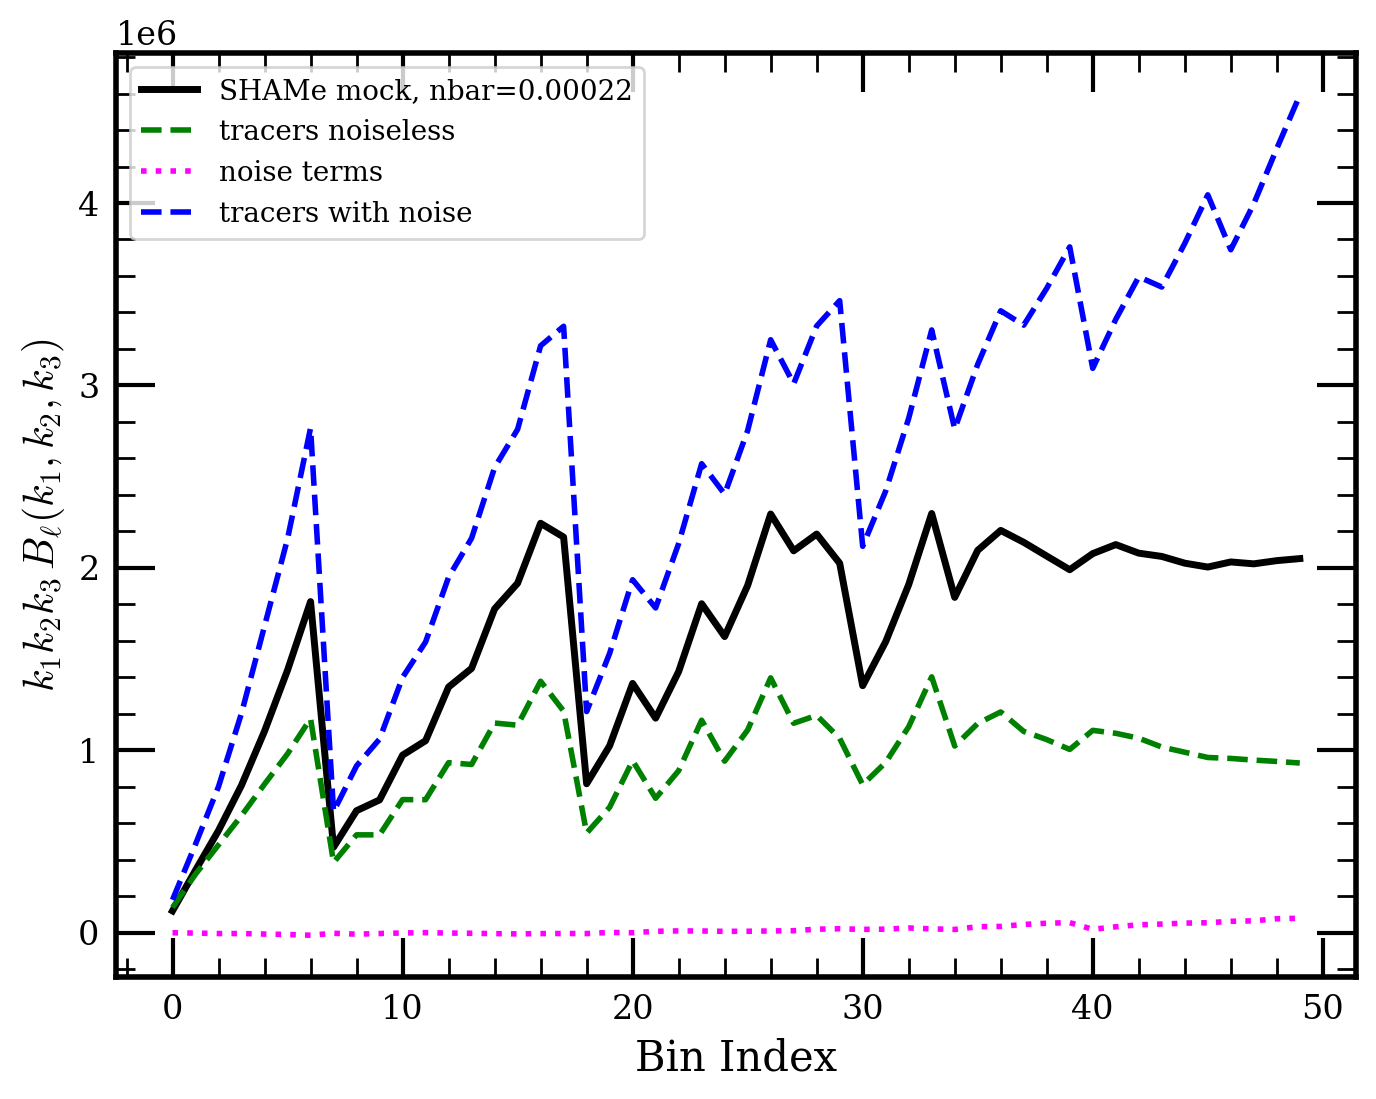

In [26]:
plt.figure(figsize=(8,6))

# ks & norm same for all
k123 = bspec_ff.get_ks()
weight = k123.prod(axis=0)

norm = n_grid**3
#norm_mock = n_grid_mock**3
#print(norm, norm_mock)

label = f'SHAMe mock, nbar={tag_mock.split("nbar")[-1]}'
label_muchisimocks = 'muchisimocks with parameters\nof SHAMe truth'
label_muchisimocks_noiseless = 'muchisimocks but noiseless'

plt.plot(y_mock[1], color='black', label=label)
plt.plot(norm**3 * weight*bk_corr_ff_det['b0'], color='green', ls='--', lw=2, label='tracers noiseless')
plt.plot(norm**3 * weight*bk_corr_ff_noise['b0'], color='magenta', ls=':', lw=2, label='noise terms')
plt.plot(norm**3 * weight*bk_corr_ff['b0'], color='blue', ls='--', lw=2, label='tracers with noise')    

plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$',fontsize=15)
plt.legend(fontsize=10)
        

In [25]:
import gc
gc.collect()

50893

In [30]:
nbar = float(tag_mock.split('nbar')[-1])

n_grid = 128
box_size = 1000.0  # Mpc/h
cell_size = box_size / n_grid  # Mpc/h per cell
cell_volume = cell_size**3
rms_cell = 1 / np.sqrt(nbar * cell_volume)

rng = np.random.default_rng(seed=42)

noise_field = rms_cell * rng.standard_normal((n_grid, n_grid, n_grid))
noise_field /= n_grid**3

In [31]:
tracer_field_noise_orig = tracer_field_ff + noise_field 

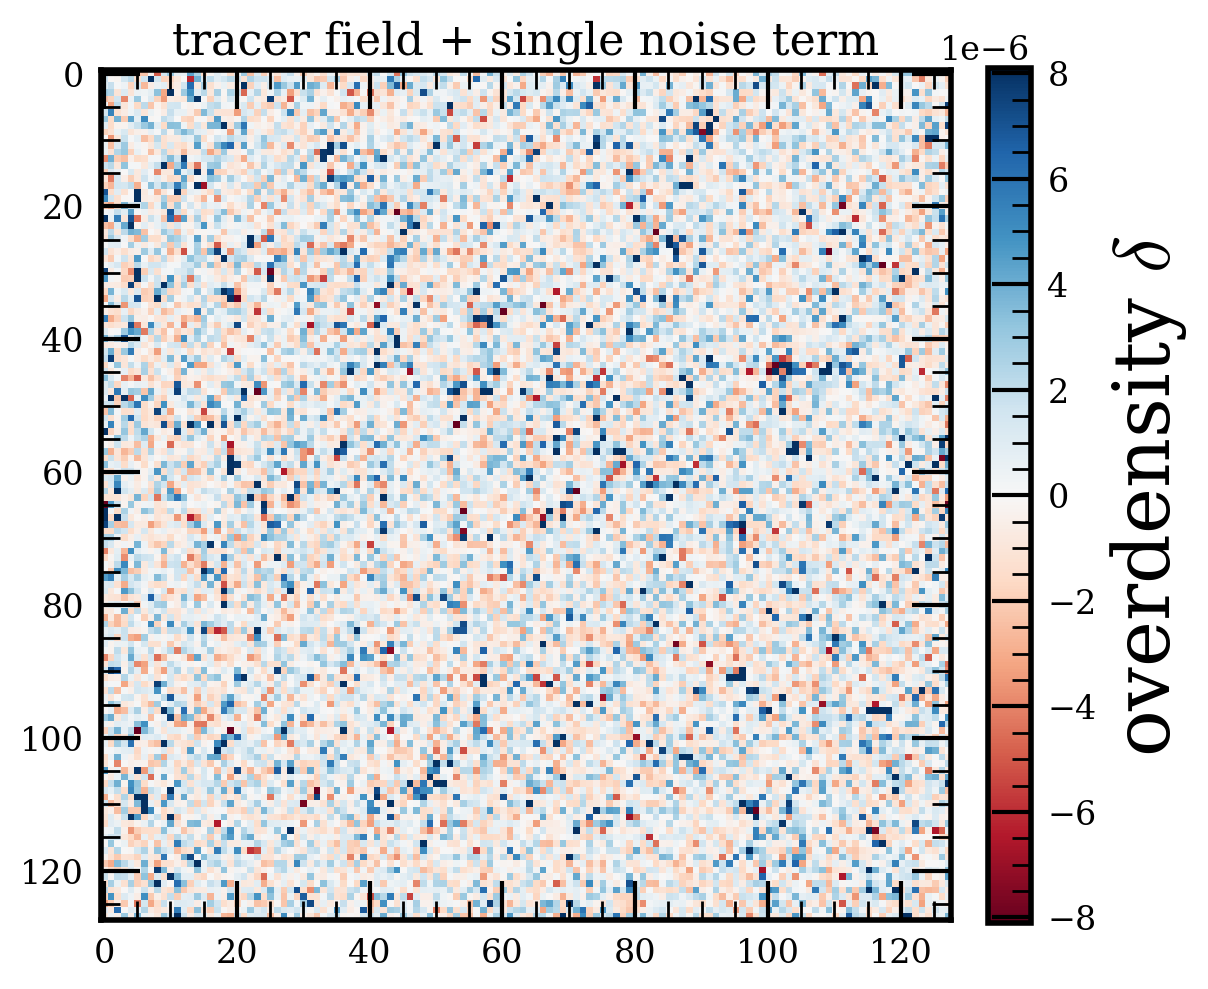

In [32]:
plotter.plot_overdensity_field(tracer_field_noise_orig, title='tracer field + single noise term')

## Mult noise implementation

In [3]:
data_mode_test = 'shame'
tag_mock = '_nbar0.00022'
tag_data_train = None # this is used for mask; we get it below 
statistics = ['pk', 'bispec']
k_mock, y_mock, y_err_mock = data_loader.load_data_ood(data_mode_test, statistics, tag_mock, tag_data=tag_data_train)

Loaded pk with shape (30,)
Loaded pk data with shape (30,)
No tag_data provided, so not masking data
Loaded bispec with shape (50,)
Loaded bispec data with shape (50,)
No tag_data provided, so not masking data


In [4]:
dir_mocks = f'/scratch/kstoreyf/muchisimocks/muchisimocks_lib_ood/shame'
subdir_prefix = 'mock'
idx_mock = 0
fn_fields = f'{dir_mocks}/{subdir_prefix}{idx_mock}/bias_fields_eul_deconvolved_{idx_mock}.npy'
bias_terms_eul = np.load(fn_fields)

In [5]:
param_dict = data_loader.load_params_ood('shame', tag_mock)
cosmo = utils.get_cosmo(param_dict)
bias_vector = [param_dict[name] for name in utils.biasparam_names_ordered]

In [6]:
n_grid = 128
rng = np.random.default_rng(seed=42)
noise_field_unit = rng.standard_normal((n_grid, n_grid, n_grid))

In [8]:
n_grid_orig = 512
#A_noise_arr = [-1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0]
A_noise_arr = [[0.0, 0.0], [0.0, 1.0], [1.0, 0.0], [1.0, 1.0], [1.0, 2.0], [2.0, 1.0], [2.0, 2.0]]
tracer_field_arr = []
for A_noise in A_noise_arr:
    
    A_noise_vec = A_noise + [0.0, 0.0, 0.0] # pad to match bias terms length
    tracer_field = utils.get_tracer_field(bias_terms_eul, bias_vector,
                                                noise_field=noise_field_unit, A_noise=A_noise_vec, n_grid_norm=n_grid_orig)
    tracer_field_arr.append(tracer_field)

In [9]:
box_size = 1000.0
pk_arr = []
for i, A_noise in enumerate(A_noise_arr):
    pk = cs.compute_pk(tracer_field_arr[i], cosmo, box_size,
                                n_threads=1, fn_stat=None)
    pk_arr.append(pk)

Computing pk, using n_grid =  128


2025-12-09 19:25:28,893 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-12-09 19:25:30,475 bacco.statistics :  ...done in 1.58 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.018511 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041911 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000123 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2025-12-09 19:25:30,476 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-12-09 19:25:30,548 bacco.statistics :  ...done in 0.0719 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.999775 (grid1) 0.999775 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013487 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041457 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000124 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2025-12-09 19:25:30,549 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-12-09 19:25:30,624 bacco.statistics :  ...done in 0.0752 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00047 (grid1) 1.00047 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.014301 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.042734 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000132 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2025-12-09 19:25:30,625 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00024 (grid1) 1.00024 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013717 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.042240 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000128 secs
bacco.power : Deallocating arrays


2025-12-09 19:25:30,707 bacco.statistics :  ...done in 0.0819 s


Computing pk, using n_grid =  128


2025-12-09 19:25:30,707 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00002 (grid1) 1.00002 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013802 sec
bacco.power : Counting modes


2025-12-09 19:25:30,790 bacco.statistics :  ...done in 0.0827 s


bacco.power : done counting modes in 0.041986 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000128 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2025-12-09 19:25:30,791 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00071 (grid1) 1.00071 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013730 sec
bacco.power : Counting modes


2025-12-09 19:25:30,871 bacco.statistics :  ...done in 0.0798 s


bacco.power : done counting modes in 0.042192 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000126 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2025-12-09 19:25:30,871 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00048 (grid1) 1.00048 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013727 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041757 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000128 secs
bacco.power : Deallocating arrays


2025-12-09 19:25:30,946 bacco.statistics :  ...done in 0.0746 s


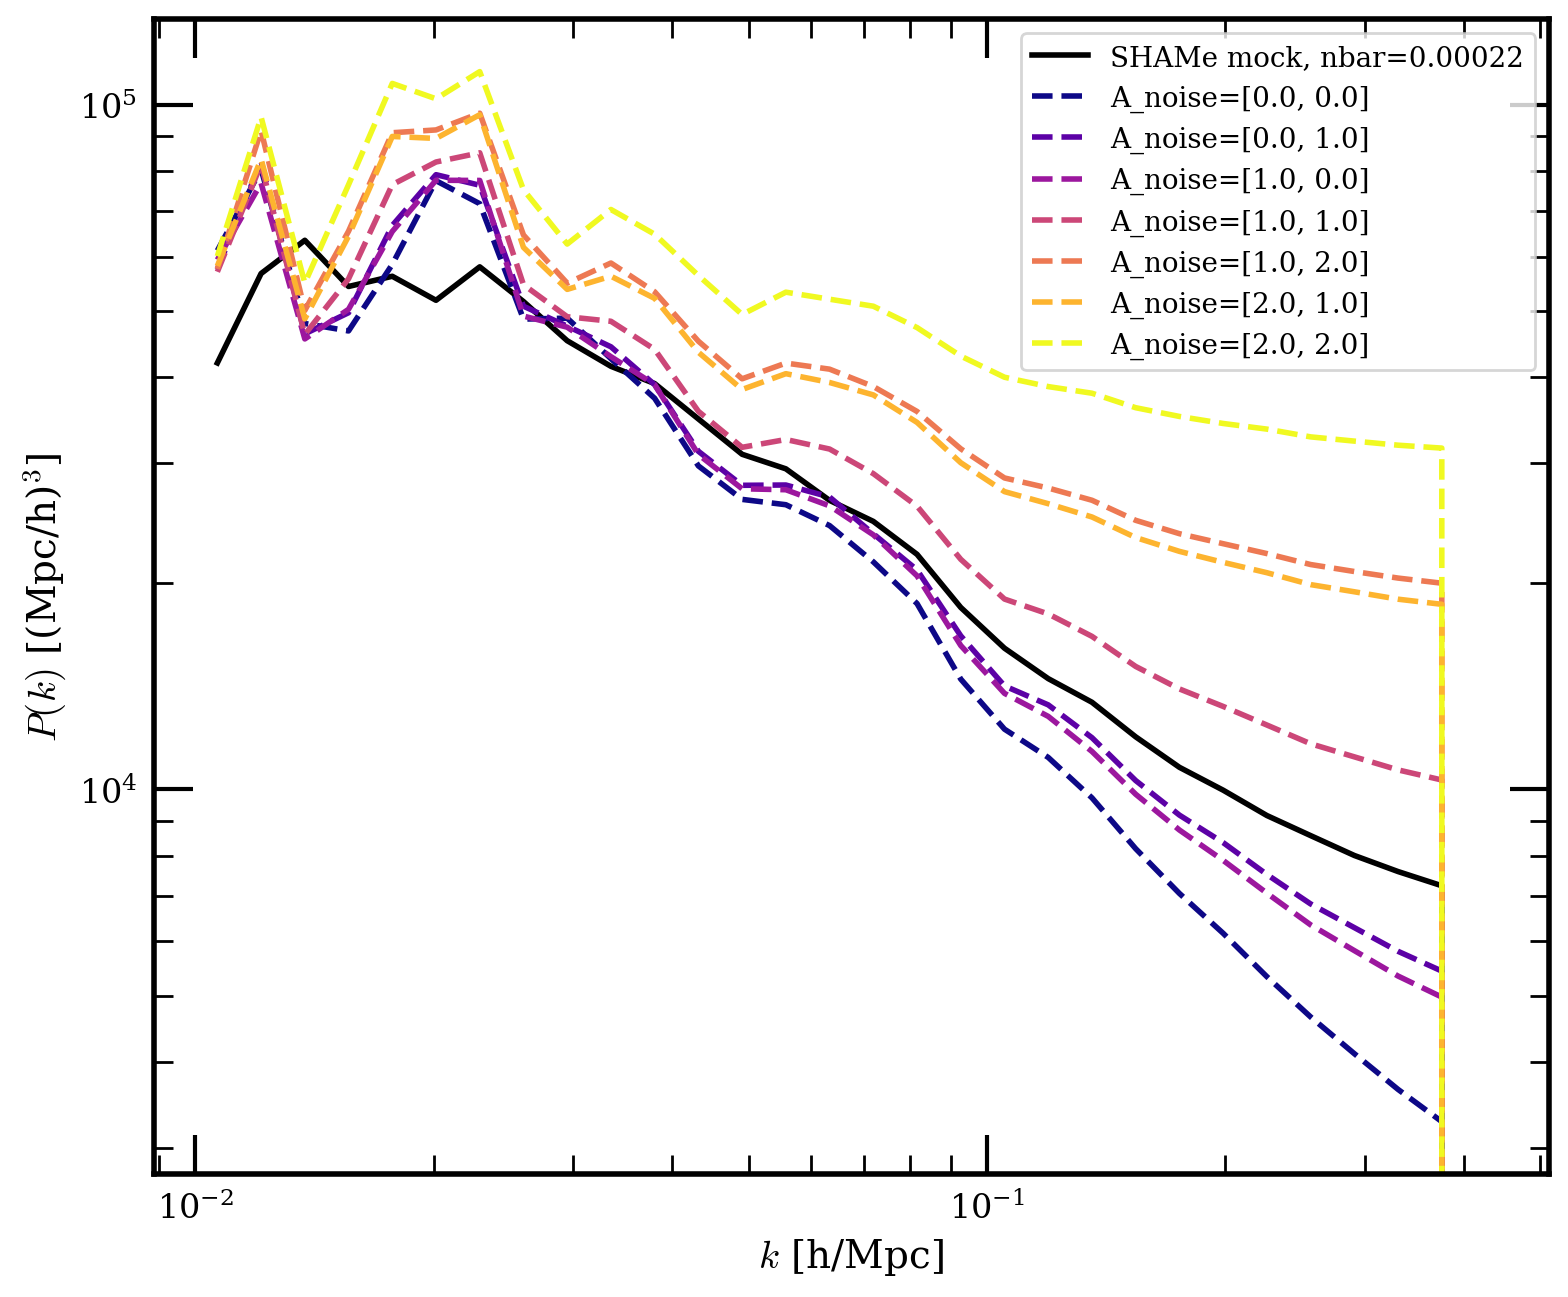

In [10]:
plt.figure(figsize=(9,7.5))
#colors = ['magenta', 'red', 'orange', 'yellow']
colors = plt.cm.plasma(np.linspace(0, 1, len(A_noise_arr)))

label = f'SHAMe mock, nbar={tag_mock.split("nbar")[-1]}'
plt.plot(k_mock[0], y_mock[0], color='black', label=label, lw=2)

for i, A_noise in enumerate(A_noise_arr):
    pk_obj = pk_arr[i]
    plt.plot(pk_obj['k'], pk_obj['pk'], color=colors[i], ls='--', label=f'A_noise={A_noise}', lw=2)

plt.xscale('log')
plt.yscale('log') 
plt.xlabel(r'$k$ [h/Mpc]', fontsize=14)
plt.ylabel(r'$P(k)$ [(Mpc/h)$^3$]', fontsize=14)

plt.legend(fontsize=10, loc='upper right')

In [11]:
import gc
gc.collect()

2031

In [12]:
box_size = 1000.0
base = cs.setup_bispsec(box_size, n_grid, n_threads=1)


# Dimensions: [1.00e+03, 1.00e+03, 1.00e+03] Mpc/h
# Center: [0.00e+00, 0.00e+00, 0.00e+00] Mpc/h
# Line-of-sight: global
# Fourier-space grid: [128, 128, 128]
# Fundamental frequency: [0.006, 0.006, 0.006] h/Mpc
# Nyquist frequency: [0.402, 0.402, 0.402] h/Mpc
# Pixel window: none
# Using fftw backend
PolyBin3D setup time: 0.19 s


In [13]:
bspec_arr, bk_corr_arr = [], []
for i, A_noise in enumerate(A_noise_arr):
    bspec, bk_corr = cs.compute_bispectrum(base, tracer_field_arr[i])
    bspec_arr.append(bspec)
    bk_corr_arr.append(bk_corr)


Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix



Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix


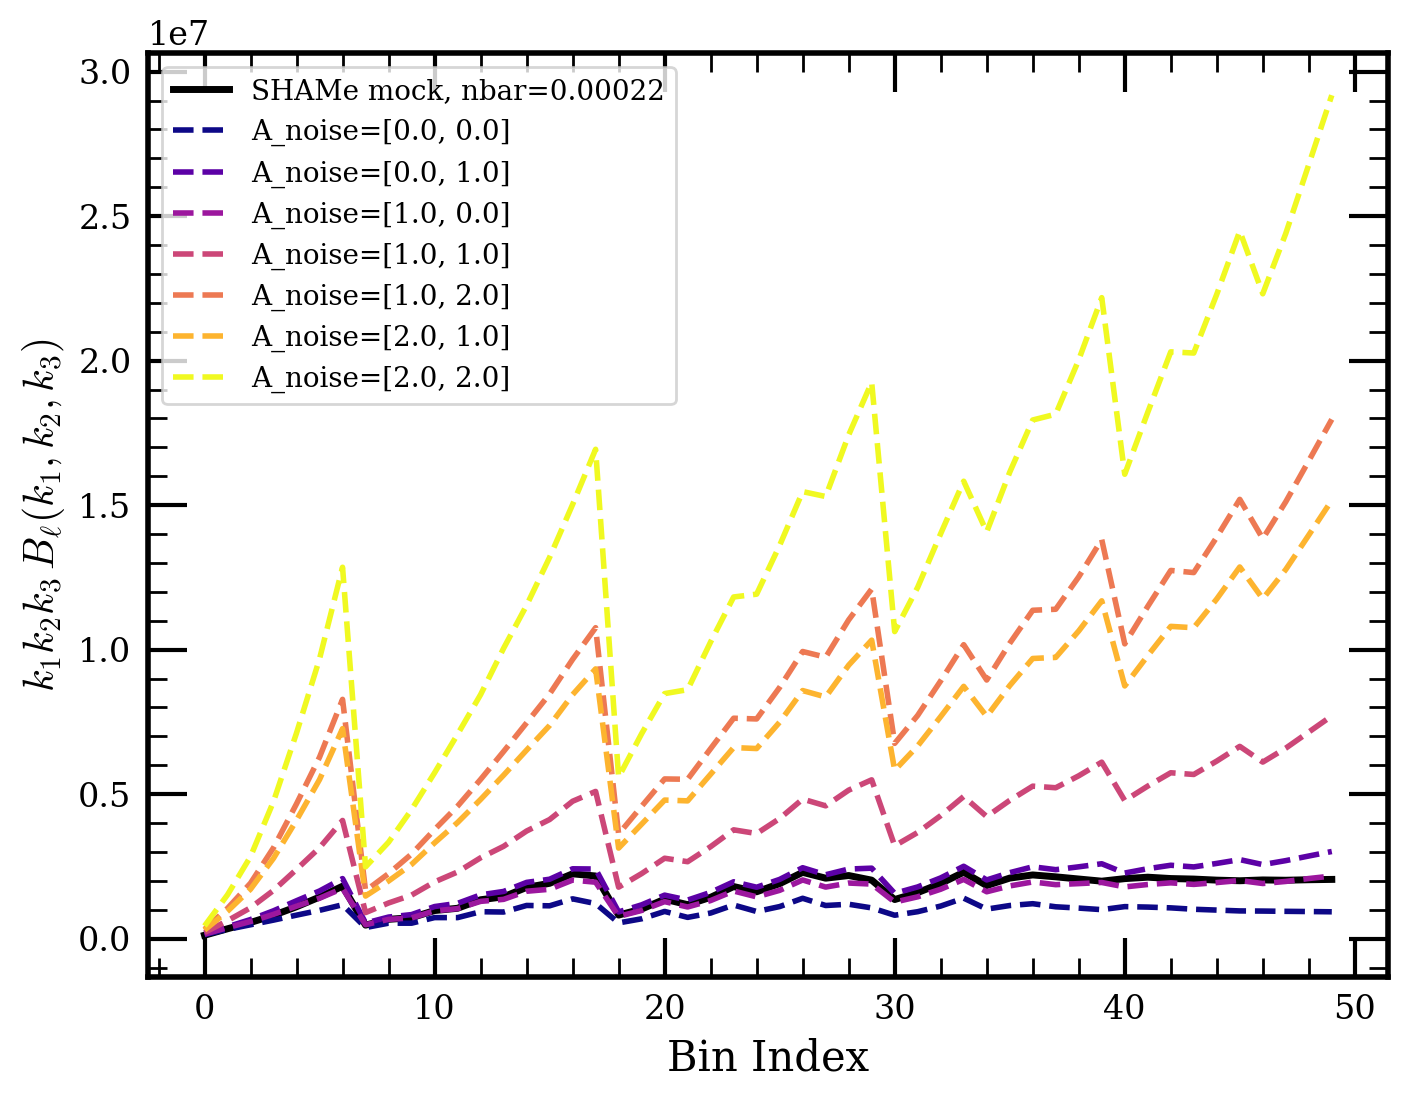

In [14]:
plt.figure(figsize=(8,6))

# ks & norm same for all
k123 = bspec_arr[0].get_ks()
weight = k123.prod(axis=0)

norm = n_grid**3
#norm_mock = n_grid_mock**3
#print(norm, norm_mock)

label = f'SHAMe mock, nbar={tag_mock.split("nbar")[-1]}'

plt.plot(y_mock[1], color='black', label=label)

for i, A_noise in enumerate(A_noise_arr):
    plt.plot(norm**3 * weight*bk_corr_arr[i]['b0'], color=colors[i], ls='--', lw=2, label=f'A_noise={A_noise}')

plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$',fontsize=15)
plt.legend(fontsize=10)
        